## adversarial-DNN

Author: Justin Tan

Adversarial training for robustness against systematic error.

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import glob, time, os
import selu
from diagnostics import *

class config(object):
    # Set network parameters
    mode = 'adv-selu'
    channel = 'B2Xsy'
    keep_prob = 0.95
    num_epochs = 512
    batch_size = 256
    n_layers = 7
    adv_n_layers = 4
    adv_keep_prob = 1.0
    hidden_layer_nodes = [1024, 1024, 512, 512, 512, 256, 256]
    adv_hidden_nodes = [256,512,512,256]
    ema_decay = 0.999
    learning_rate = 1e-5
    adv_learning_rate = 0.001
    adv_lambda = 8
    cycles = 3 # Number of annealing cycles
    n_classes = 2
    adv_n_classes = 10
    epsilon = 1e-8
    builder = 'selu'
    K = 4
    adversary = True
    pivots = ['deltae','mbc']

class directories(object):
    train = '/data/projects/punim0011/jtan/spark/spark2tf/cont_b2sy_By_val.parquet'# '/home/jtan/gpu/jtan/spark/spark2tf/example_train.tfrecords'
    test = '/data/projects/punim0011/jtan/spark/spark2tf/cont_b2sy_By_test.parquet'#'/home/jtan/gpu/jtan/spark/spark2tf/example_test.tfrecords'
    val = '/data/projects/punim0011/jtan/spark/spark2tf/cont_b2sy_By_train.parquet'#'/home/jtan/gpu/jtan/spark/spark2tf/example_test.tfrecords'
    tensorboard = 'tensorboard'
    checkpoints = 'checkpoints'
    best_checkpoints = 'best' 

architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)
get_available_gpus()

def load_parquet(datasetName, subsample=False, dropFrac=0.75):
    from sklearn.model_selection import train_test_split
    
    excludeFeatures = ['labels', 'mbc', 'deltae', 'daughterInvM', 'nCands', 'evtNum', 'MCtype', 'channel']
    dataset = pq.ParquetDataset(datasetName)
    pdf = dataset.read(nthreads=4).to_pandas()
    pdf = pdf.sample(frac=1).reset_index(drop=True)
    features = pdf.drop(excludeFeatures, axis=1)
    labels = pdf['labels'].astype(np.int32)
    auxillary = pdf[['deltae', 'mbc']]
    auxillary=auxillary.assign(dE_labels=pd.qcut(auxillary['deltae'], q=config.adv_n_classes, labels=False), 
                               mbc_labels=pd.qcut(auxillary['mbc'], q=config.adv_n_classes, labels=False))
    
    return features.values.astype(np.float32), labels.values, auxillary.values.astype(np.float32), pdf

Available GPUs:
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']


In [4]:
features, labels, auxillary, pdf = load_parquet(directories.train)
featuresTest, labelsTest, auxillaryTest, pdf_test = load_parquet(directories.test)
config.nTrainExamples, config.nFeatures = features.shape[0], features.shape[-1]
config.steps_per_epoch = features.shape[0] // config.batch_size

In [5]:
def dataset_placeholder(features_placeholder, labels_placeholder, batchSize, numEpochs, training=True):  
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dataset_placeholder_aux(features_placeholder, labels_placeholder, auxillary_placeholder, batchSize, numEpochs, training=True, shuffle=True):  
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder, auxillary_placeholder))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dataset_placeholder_plot(features_placeholder, labels_placeholder, auxillary_placeholder, batchSize=51200, training=False):  
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder, auxillary_placeholder))
    dataset = dataset.batch(int(int(features_placeholder.get_shape()[0])/8))
    dataset = dataset.repeat()

    return dataset

def dataset_single_epoch(features, labels, auxillary, batchSize, training=True):
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features, labels, auxillary))
    dataset = dataset.shuffle(buffer_size=25600)
    dataset = dataset.batch(batchSize)
    
    return dataset

def dataset_train(dataDirectory, batchSize, numEpochs, nFeatures, training=True):
    filenames = glob.glob('{}/part*'.format(dataDirectory))
    dataset = tf.contrib.data.TFRecordDataset(filenames)

    # Extract data from `tf.Example` protocol buffer
    def parser(record, batchSize=128):
        keys_to_features = {
            "features": tf.FixedLenFeature([nFeatures], tf.float32),
            "labels": tf.FixedLenFeature((), tf.float32,
            default_value=tf.zeros([], dtype=tf.float32)),
#             "mbc": tf.FixedLenFeature((), tf.float32, dtype=tf.float32),
#             "deltae": tf.FixedLenFeature((), tf.float32, dtype=tf.float32)
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        label = tf.cast(parsed['labels'], tf.int32)

        return parsed['features'], label

    # Transform into feature, label tensor pair
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dense_builder(x, shape, name, keep_prob, training=True, actv=tf.nn.elu):
    init=tf.contrib.layers.xavier_initializer()
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': True}

    with tf.variable_scope(name, initializer=init) as scope:
        layer = tf.layers.dense(x, units=shape[1], activation=actv)
        bn = tf.layers.batch_normalization(layer, **kwargs)
        layer_out = tf.layers.dropout(bn, 1-keep_prob, training=training)

    return layer_out

def selu_builder(x, shape, name, keep_prob, training=True):
    init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope(name) as scope:
        W = tf.get_variable("weights", shape = shape, initializer=init)
        b = tf.get_variable("biases", shape = [shape[1]], initializer=tf.random_normal_initializer(stddev=0.01))
        actv = selu.selu(tf.add(tf.matmul(x, W), b))
        layer_output = selu.dropout_selu(actv, rate=1-keep_prob, training=training)

    return layer_output

def dense_model(x, n_layers, hidden_layer_nodes, keep_prob, n_input, n_classes, scope, builder=selu_builder, reuse=False, training=True):
    # Extensible dense model
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')
    init = SELU_initializer if builder==selu_builder else tf.contrib.layers.xavier_initializer()
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]

    with tf.variable_scope(scope, reuse=reuse):
        hidden_0 = builder(x, shape=[n_input, hidden_layer_nodes[0]], name='hidden0',
                                keep_prob = keep_prob, training=training)
        layers.append(hidden_0)
        for n in range(0,n_layers-1):
            hidden_n = builder(layers[-1], shape=[hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name='hidden{}'.format(n+1),
                                keep_prob=keep_prob, training=training)
            layers.append(hidden_n)

        readout = tf.layers.dense(hidden_n, units=n_classes, kernel_initializer=init)

    return readout

def scope_variables(name):
    with tf.variable_scope(name):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                       scope=tf.get_variable_scope().name)

In [6]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training=True, cyclical=False):
        
        self.global_step = tf.Variable(0, trainable=False)
        self.handle = tf.placeholder(tf.string, shape=[])
        self.training_phase = tf.placeholder(tf.bool)
        self.beta = tf.placeholder(tf.float32) if cyclical else config.learning_rate
#         self.beta = tf.train.exponential_decay(config.learning_rate, self.global_step, 
#                                                decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)
        self.features_placeholder = tf.placeholder(features.dtype, features.shape)
        self.labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
        self.auxillary_placeholder = tf.placeholder(auxillary.dtype, auxillary.shape)
        self.featuresTest_placeholder = tf.placeholder(features.dtype, featuresTest.shape)
        self.labelsTest_placeholder = tf.placeholder(labels.dtype, labelsTest.shape)
        self.auxillaryTest_placeholder = tf.placeholder(auxillary.dtype, auxillaryTest.shape)

        preTrainDataset = dataset_single_epoch(self.features_placeholder, self.labels_placeholder, self.auxillary_placeholder, config.batch_size, training=True)
        trainDataset = dataset_placeholder_aux(self.features_placeholder, self.labels_placeholder, self.auxillary_placeholder,
                                           config.batch_size, config.num_epochs, training=True)
        testDataset = dataset_placeholder_aux(self.featuresTest_placeholder, self.labelsTest_placeholder, self.auxillaryTest_placeholder,
                                          config.batch_size, config.num_epochs, training=True)
        plotDataset = dataset_placeholder_plot(self.featuresTest_placeholder, self.labelsTest_placeholder, self.auxillaryTest_placeholder)
                        
        self.iterator = tf.contrib.data.Iterator.from_string_handle(self.handle, trainDataset.output_types, trainDataset.output_shapes)
        self.pretrain_iterator = preTrainDataset.make_initializable_iterator()
        self.train_iterator = trainDataset.make_initializable_iterator()
        self.test_iterator = testDataset.make_initializable_iterator()
        self.plot_iterator = plotDataset.make_initializable_iterator()

        self.example, self.label, self.ancillary = self.iterator.get_next()
        self.readout = dense_model(self.example, config.n_layers, config.hidden_layer_nodes, config.keep_prob, builder=selu_builder, 
                                   n_input=config.nFeatures, n_classes=config.n_classes, reuse=False, training=self.training_phase, scope='predictor')

        # Introduce a separate adversary network for each pivot
        for i in range(len(config.pivots)):
            # for mode in ['signal', 'background']:
            mode = 'background'
            print('Building {} adversary for {} events.'.format(config.pivots[i], mode))
            adversary_readout = dense_model(tf.nn.softmax(self.readout), config.adv_n_layers, config.adv_hidden_nodes, config.adv_keep_prob, n_input=2, 
                    n_classes=config.adv_n_classes, training=self.training_phase, scope='adversary_{}_{}'.format(config.pivots[i], mode))
            # mask = tf.cast(self.label - (not mode=='signal'), tf.float32)
            adversary_loss = tf.reduce_mean(tf.cast((1-self.label), tf.float32)*tf.nn.sparse_softmax_cross_entropy_with_logits(logits=adversary_readout, 
                                                                                                labels=tf.cast(self.ancillary[:,i+2], tf.int32)))
#             adversary_loss = tf.reduce_mean(mask*tf.nn.sparse_softmax_cross_entropy_with_logits(logits=adversary_readout, 
#                                                                                                 labels=tf.cast(self.ancillary[:,i+2], tf.int32)))
            tf.add_to_collection('adversary_losses', adversary_loss)
            
        # Mask signal values in adversary loss
        self.adversary_loss = tf.add_n(tf.get_collection('adversary_losses'), name='total_adversary_loss')
        self.predictor_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.readout, labels=self.label))
        self.total_loss = self.predictor_loss - config.adv_lambda*self.adversary_loss
        
        theta_f = scope_variables('predictor')
        theta_r = scope_variables('adversary')
        self.theta = theta_f, theta_r

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            # Ensures that we execute the update_ops before performing the train_step
            predictor_optimizer = tf.train.AdamOptimizer(config.learning_rate)
            predictor_gs = tf.Variable(0, name='predictor_global_step', trainable=False)
            self.predictor_train_op = predictor_optimizer.minimize(self.predictor_loss, name='predictor_opt', global_step=predictor_gs, var_list=theta_f)
            predictor_optimize = predictor_optimizer.minimize(self.total_loss, name='predictor_opt', global_step=predictor_gs, var_list=theta_f)
            # self.joint_train_op = predictor_optimizer.minimize(self.total_loss, name='joint_opt', global_step=predictor_gs, var_list=theta_f)

            adversary_optimizer = tf.train.AdamOptimizer(config.adv_learning_rate)
            adversary_gs = tf.Variable(0, name='adversary_global_step', trainable=False)
            self.adversary_train_op = adversary_optimizer.minimize(self.adversary_loss, name='adversary_opt', global_step=adversary_gs, var_list=theta_r)

        self.ema = tf.train.ExponentialMovingAverage(decay=config.ema_decay, num_updates=predictor_gs, name='predictor_ema')
        maintain_predictor_averages_op = self.ema.apply(theta_f)
        with tf.control_dependencies([predictor_optimize]):
            self.joint_train_op = tf.group(maintain_predictor_averages_op)

        # Evaluation metrics
        self.cross_entropy = self.predictor_loss
        self.p = tf.nn.softmax(self.readout)
        self.transform = tf.log(self.p[:,1]/(1-self.p[:,1]+config.epsilon)+config.epsilon)
        correct_prediction = tf.equal(tf.cast(tf.argmax(self.readout, 1), tf.int32), self.label)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        _, self.auc_op = tf.metrics.auc(predictions = tf.argmax(self.readout,1), labels = self.label, num_thresholds = 1024)
        self.pearson_dE, self.pearson_dE_op =  tf.contrib.metrics.streaming_pearson_correlation(predictions=self.transform,
                                                                                                labels=self.ancillary[:,0], name='pearson_dE')
        self.pearson_mbc, self.pearson_mbc_op =  tf.contrib.metrics.streaming_pearson_correlation(predictions=self.transform,
                                                                                                  labels=self.ancillary[:,1], name='pearson_mbc')
        self.adv_xentropy = self.adversary_loss
        adv_correct_prediction = tf.equal(tf.cast(tf.argmax(adversary_readout,1), tf.int32), tf.cast(self.ancillary[:,3], tf.int32))
        self.adv_accuracy = tf.reduce_mean(tf.cast(adv_correct_prediction, tf.float32))
        
        tf.summary.scalar('accuracy', self.accuracy)
        tf.summary.scalar('auc', self.auc_op)
        tf.summary.scalar('learning_rate', self.beta)
        tf.summary.scalar('predictor_loss', self.predictor_loss)
        tf.summary.scalar('adversary_loss', self.adversary_loss)
        tf.summary.scalar('total_loss', self.total_loss)        
        tf.summary.scalar('pearson_dE', self.pearson_dE_op)
        tf.summary.scalar('pearson_mbc', self.pearson_mbc_op)
        
        self.merge_op = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'train_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'test_{}'.format(time.strftime('%d-%m_%I:%M'))))

    def predict(self, ckpt):
        pin_cpu = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, device_count = {'GPU':0})
        start_time = time.time()
        
        # Restore the moving average version of the learned variables for eval.
        variables_to_restore = self.ema.variables_to_restore().update(dict((v, v) for v in scope_variables('adversary')))
        
        saver = tf.train.Saver(variables_to_restore)
        # saver = tf.train.Saver()
        valDataset = dataset_placeholder_aux(self.featuresTest_placeholder, self.labelsTest_placeholder, self.auxillaryTest_placeholder,
                                          config.batch_size, config.num_epochs, training=False, shuffle=False)
        val_iterator = valDataset.make_initializable_iterator()
        concatLabels = tf.cast(self.label, tf.int32)
        concatPreds = tf.cast(tf.argmax(self.readout,1), tf.int32)
        concatOutput = self.p[:,1]

        with tf.Session(config=pin_cpu) as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())
            assert (ckpt.model_checkpoint_path), 'Missing checkpoint file!'    
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            val_handle = sess.run(val_iterator.string_handle())
            labels, preds, outputs = [], [], []
            sess.run(val_iterator.initializer, feed_dict={vDNN.featuresTest_placeholder: featuresTest,
                                                          vDNN.labelsTest_placeholder: labelsTest, 
                                                          vDNN.auxillaryTest_placeholder: auxillaryTest})
            while True:
                try:
                    l, p, o = sess.run([concatLabels, concatPreds, concatOutput], 
                                       feed_dict = {vDNN.training_phase: False, vDNN.handle: val_handle})
                    labels.append(l), preds.append(p), outputs.append(o)
                except tf.errors.OutOfRangeError:
                    labels, preds, outputs = np.concatenate(labels), np.concatenate(preds), np.concatenate(outputs)
                    break
            acc = np.mean(np.equal(labels,preds))
            print("Validation accuracy: {:.3f}".format(acc))
            
            plot_ROC_curve(network_output=outputs, y_true=labels, identifier=config.mode+config.channel,
                           meta=architecture + ' | Test accuracy: {:.3f}'.format(acc))
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return labels, preds, outputs

In [ ]:
def train(config, restore = False):
    # Executes training operations
    print('Architecture: {}'.format(architecture))
    vDNN = vanillaDNN(config, training=True)
    start_time = time.time()
    global_step, v_auc_best = 0, 0.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        pretrain_handle = sess.run(vDNN.pretrain_iterator.string_handle())
        train_handle = sess.run(vDNN.train_iterator.string_handle())
        test_handle = sess.run(vDNN.test_iterator.string_handle())
        plot_handle = sess.run(vDNN.plot_iterator.string_handle())
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            
        train_init = {vDNN.features_placeholder: features, vDNN.labels_placeholder: labels, vDNN.auxillary_placeholder: auxillary}
        test_init = {vDNN.featuresTest_placeholder: featuresTest, vDNN.labelsTest_placeholder: labelsTest, vDNN.auxillaryTest_placeholder: auxillaryTest}
        pretrain_feed = {vDNN.training_phase: True, vDNN.handle: pretrain_handle}
        train_feed = {vDNN.training_phase: True, vDNN.handle: train_handle}
        sess.run(vDNN.train_iterator.initializer, feed_dict=train_init)
        sess.run(vDNN.test_iterator.initializer, feed_dict=test_init)
        sess.run(vDNN.plot_iterator.initializer, feed_dict=test_init)
        
        def pretrain(iterator, train_op, feed_dict_init, feed_dict_train, n_epochs):
            for epoch in range(n_epochs):
                sess.run(iterator.initializer, feed_dict=feed_dict_init)
                while True:
                    try:
                        sess.run(train_op, feed_dict=feed_dict_train)
                    except tf.errors.OutOfRangeError:
                        break

                plot_distributions(vDNN, epoch, sess, handle=plot_handle)
                run_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, global_step, 
                                config.nTrainExamples, start_time, v_auc_best, epoch)
        
#         pretrain(vDNN.pretrain_iterator, train_op=vDNN.predictor_train_op, feed_dict_init=train_init, feed_dict_train=pretrain_feed, n_epochs=5)
#         pretrain(vDNN.pretrain_iterator, train_op=vDNN.adversary_train_op, feed_dict_init=train_init, feed_dict_train=pretrain_feed, n_epochs=1)

        while True:
            try:
                if config.adversary:
                    # adversary trains in inner loop
                    if global_step % config.K == 0:
                        sess.run(vDNN.joint_train_op, feed_dict=train_feed)
                    else:
                        sess.run(vDNN.adversary_train_op, feed_dict=train_feed)
                    global_step+=1

                    if global_step % (config.steps_per_epoch) == 0:
                        epoch, v_auc_best = run_adv_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, 
                                                            global_step, config.nTrainExamples, start_time, v_auc_best)
                        plot_distributions(vDNN, epoch, sess, handle=plot_handle)
                else:
                    # Run X steps on training dataset
                    sess.run(vDNN.predictor_train_op, feed_dict=train_feed)
                    global_step+=1

                    if global_step % (config.steps_per_epoch // 4) == 0:
                        epoch, v_auc_best = run_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, 
                                                            global_step, config.nTrainExamples, start_time, v_auc_best)

            except tf.errors.OutOfRangeError:
                break

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)), global_step=epoch)
    
    print("Training Complete. Model saved to file: {} Time elapsed: {:.3f} s".format(save_path, time.time()-start_time))

Architecture: B2Xsy - adv-selu | Layers: 7 | Dropout: 0.95 | Base LR: 1e-05 | Epochs: 512
Building deltae adversary for background events.
Building mbc adversary for background events.
Graph saved to file: checkpoints/vDNN_adv-selu_B2Xsy_epoch0.ckpt-0
Epoch 0, Step 1321728 | Training Acc: 0.928 | Test Acc: 0.965 | Test Loss: 0.116 | Test AUC: 0.919 | Total loss: -8.198 | Rate: 295 examples/s (53.39 s) [*]
Post-selection: 75
Normalized BG deviation:  1.49418758256


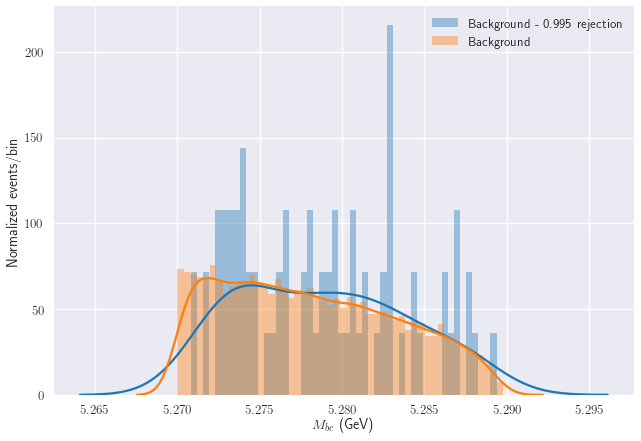

Post-selection: 75
Normalized BG deviation:  1.46763540291


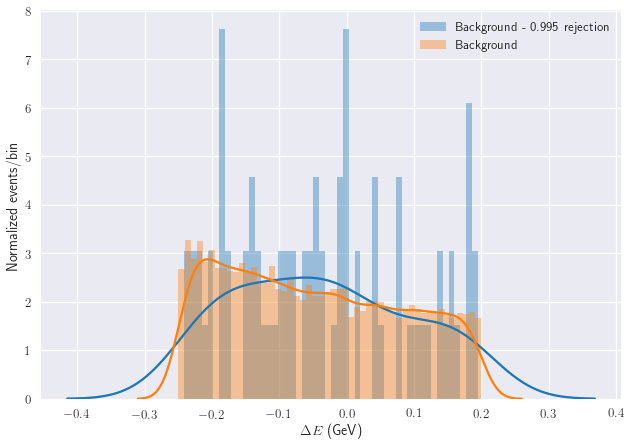

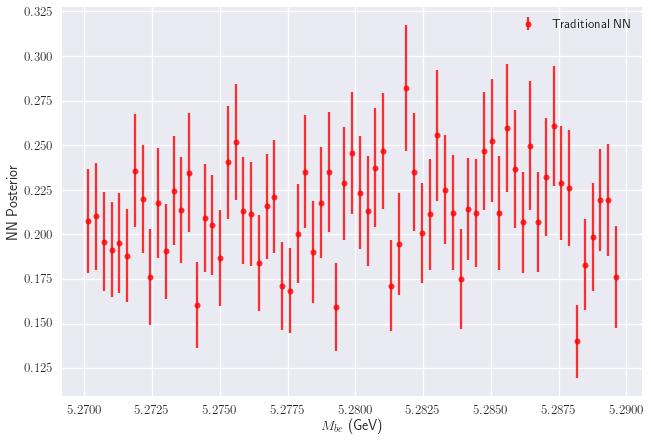

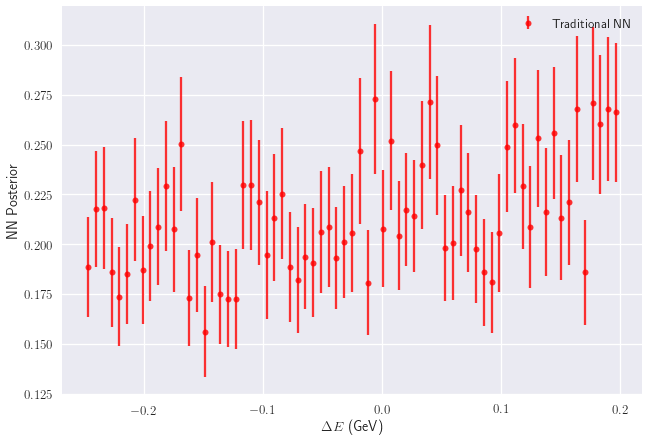

Epoch 1, Step 1321491 | Training Acc: 0.954 | Test Acc: 0.918 | Test Loss: 0.309 | Test AUC: 0.885 | Total loss: -7.484 | Rate: 1702 examples/s (113.03 s) 
Post-selection: 75
Normalized BG deviation:  1.41445927106


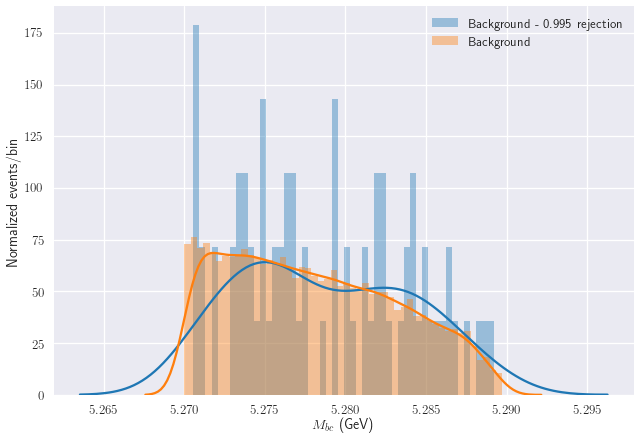

Post-selection: 75
Normalized BG deviation:  1.48496315475


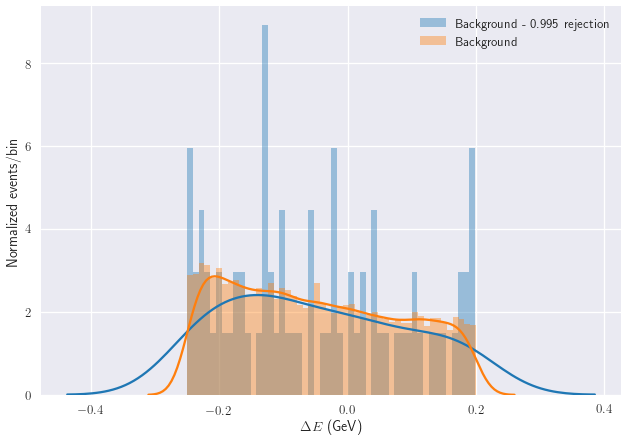

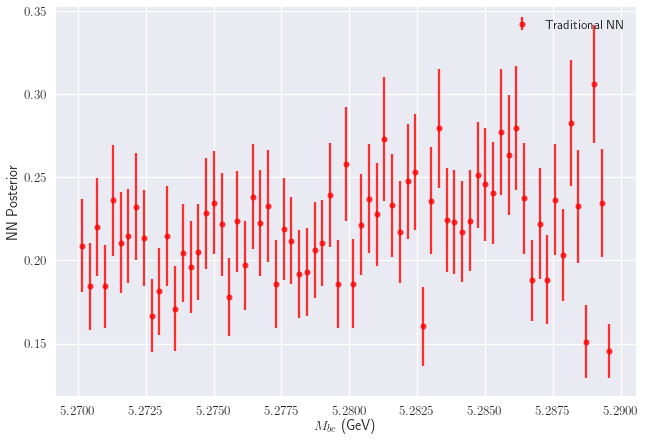

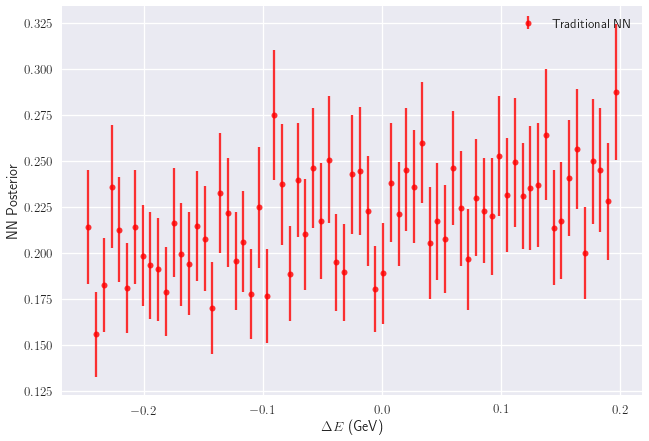

Epoch 2, Step 1321254 | Training Acc: 0.966 | Test Acc: 0.930 | Test Loss: 0.170 | Test AUC: 0.884 | Total loss: -7.115 | Rate: 1795 examples/s (168.05 s) 
Post-selection: 76
Normalized BG deviation:  1.51754385965


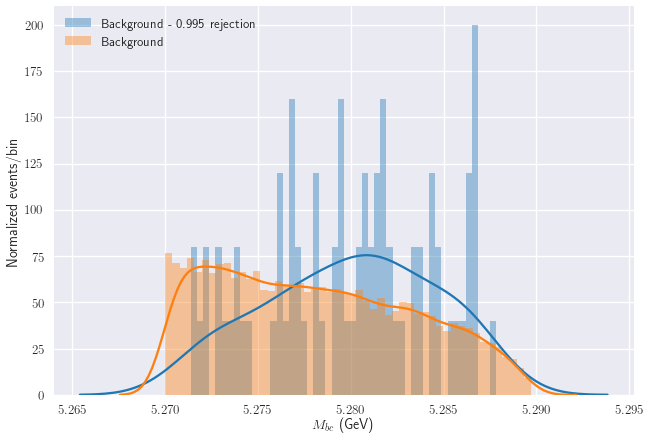

Post-selection: 76
Normalized BG deviation:  1.51610369207


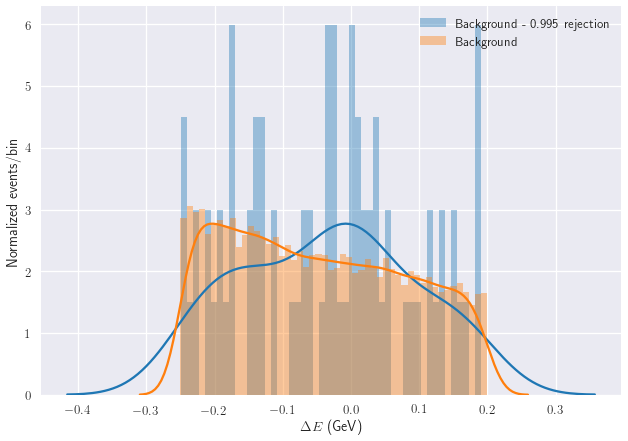

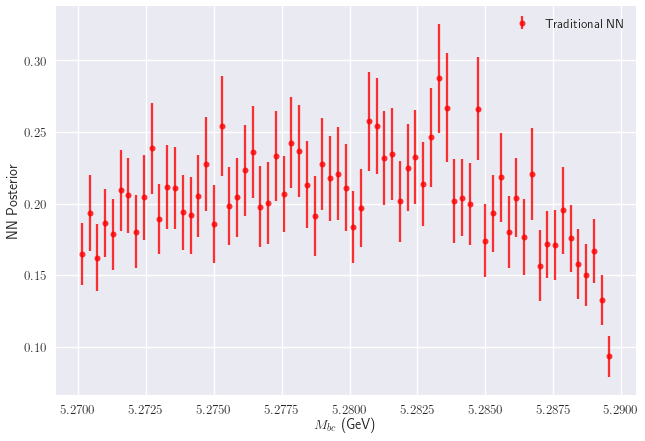

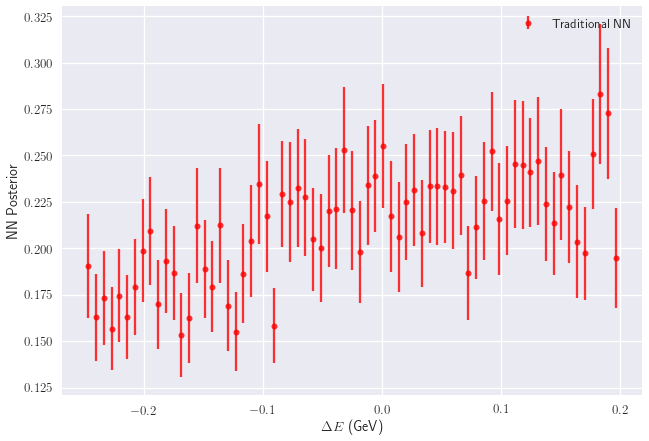

Epoch 3, Step 1321017 | Training Acc: 0.958 | Test Acc: 0.941 | Test Loss: 0.148 | Test AUC: 0.919 | Total loss: -6.754 | Rate: 1815 examples/s (225.12 s) 
Post-selection: 76
Normalized BG deviation:  1.54997705971


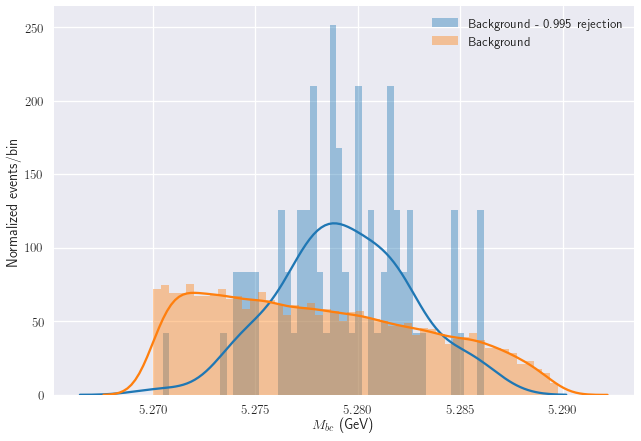

Post-selection: 76
Normalized BG deviation:  1.48718620961


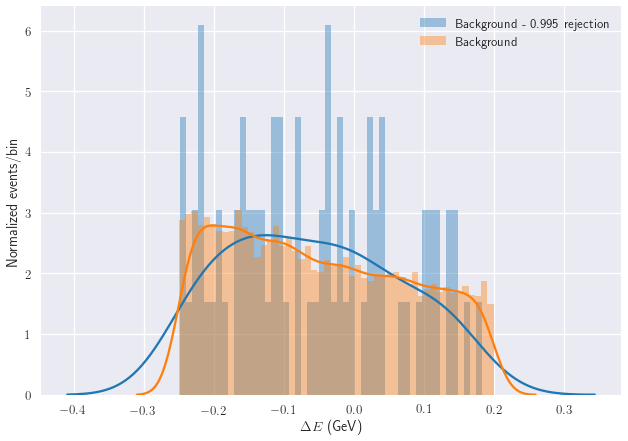

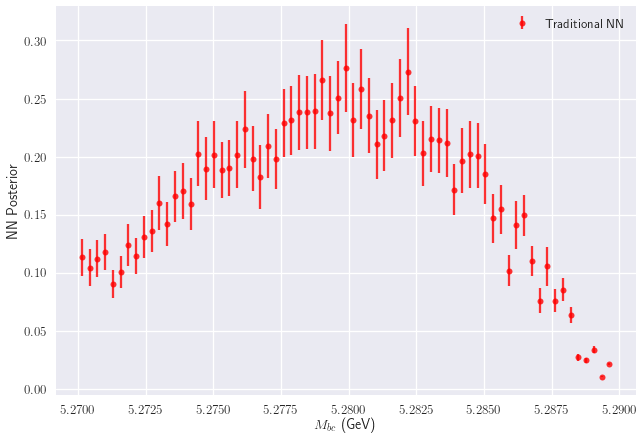

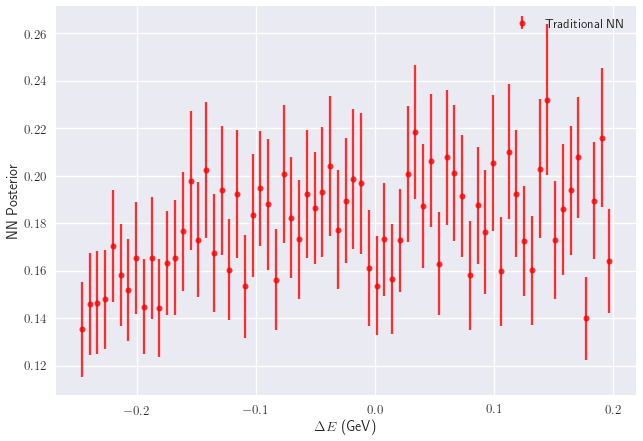

Epoch 4, Step 1320780 | Training Acc: 0.945 | Test Acc: 0.945 | Test Loss: 0.188 | Test AUC: 0.914 | Total loss: -7.700 | Rate: 1822 examples/s (280.25 s) 
Post-selection: 76
Normalized BG deviation:  1.47230759171


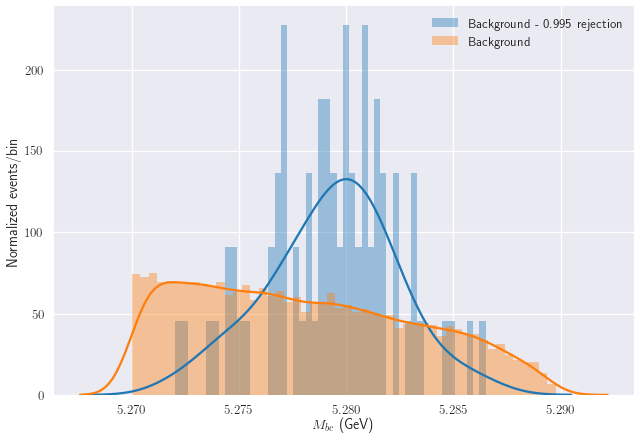

Post-selection: 76
Normalized BG deviation:  1.49192440986


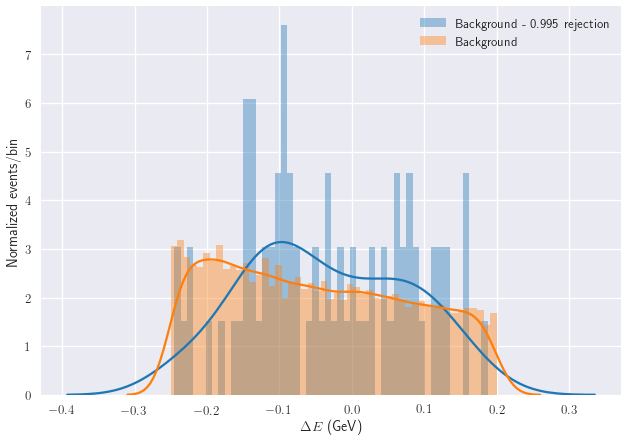

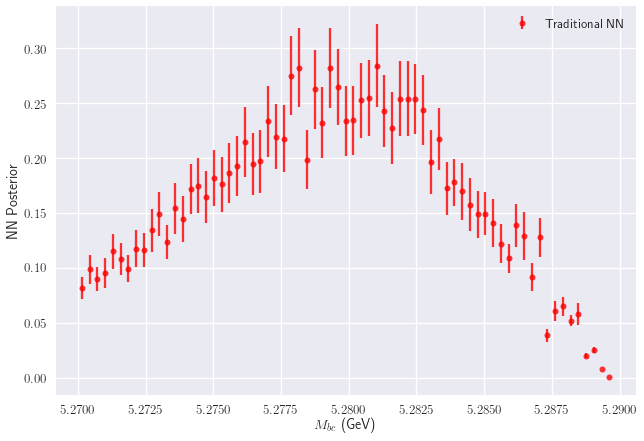

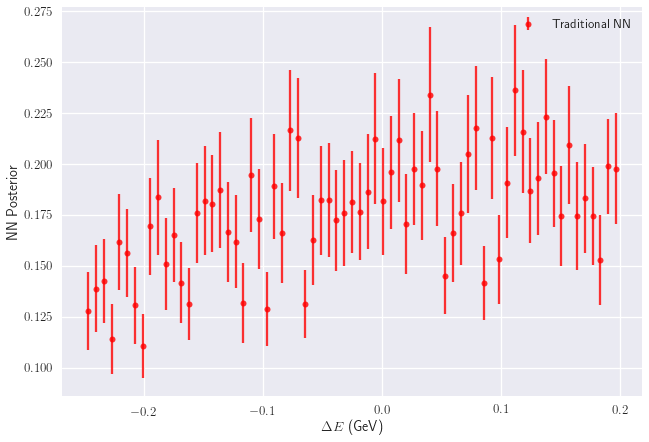

Epoch 5, Step 1320543 | Training Acc: 0.937 | Test Acc: 0.957 | Test Loss: 0.174 | Test AUC: 0.899 | Total loss: -7.259 | Rate: 1815 examples/s (335.90 s) 
Post-selection: 75
Normalized BG deviation:  1.51562189055


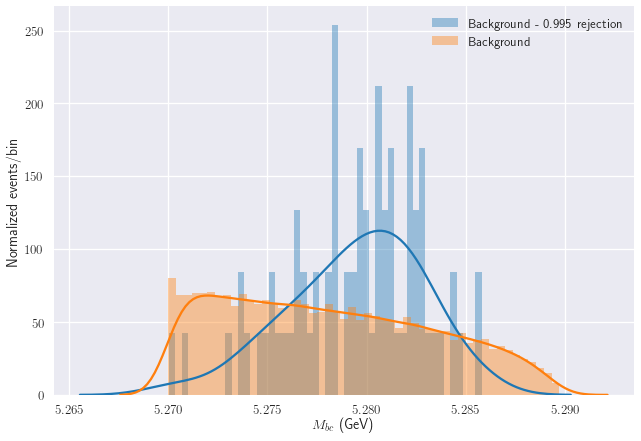

Post-selection: 75
Normalized BG deviation:  1.50262023217


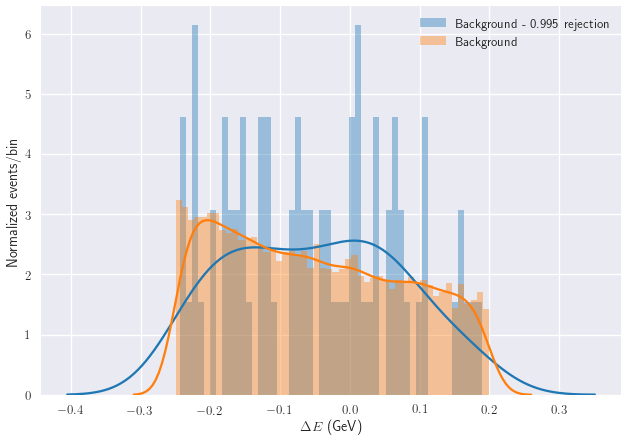

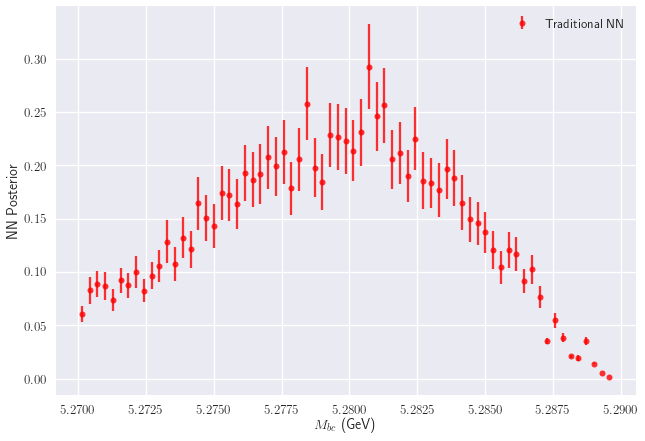

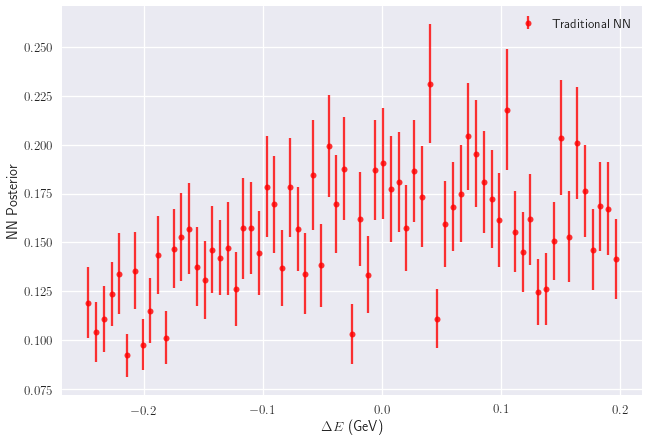

Graph saved to file: best/vDNN_adv-selu_B2Xsy_epoch6.ckpt-6
Epoch 6, Step 1320306 | Training Acc: 0.954 | Test Acc: 0.957 | Test Loss: 0.185 | Test AUC: 0.925 | Total loss: -7.014 | Rate: 402 examples/s (390.52 s) [*]
Post-selection: 75
Normalized BG deviation:  1.58318413898


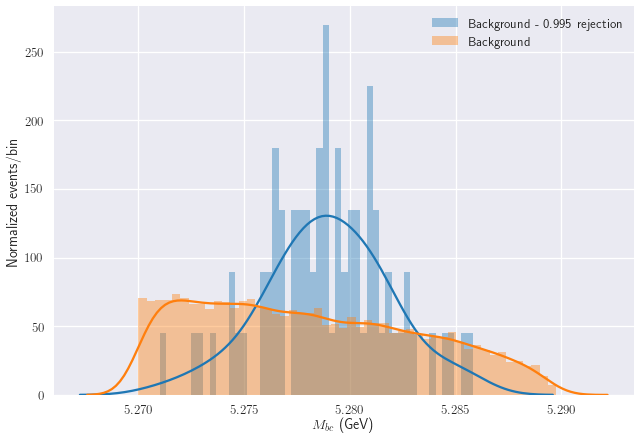

Post-selection: 75
Normalized BG deviation:  1.47523373782


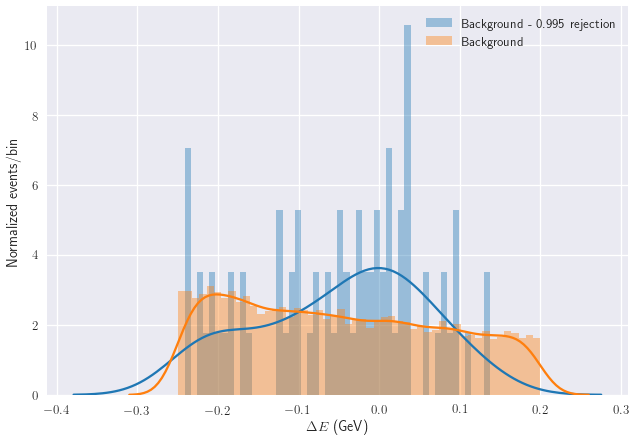

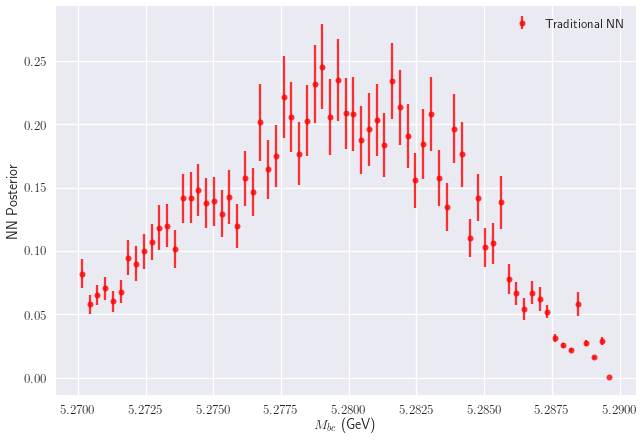

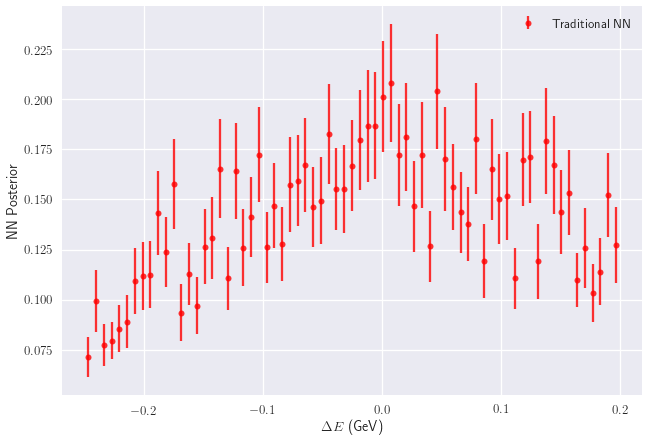

Epoch 7, Step 1320069 | Training Acc: 0.958 | Test Acc: 0.945 | Test Loss: 0.172 | Test AUC: 0.923 | Total loss: -6.852 | Rate: 1822 examples/s (445.18 s) 
Post-selection: 75
Normalized BG deviation:  1.49705434567


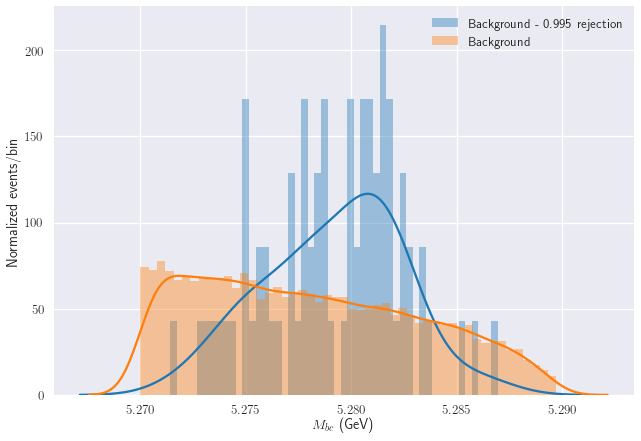

Post-selection: 75
Normalized BG deviation:  1.49440656649


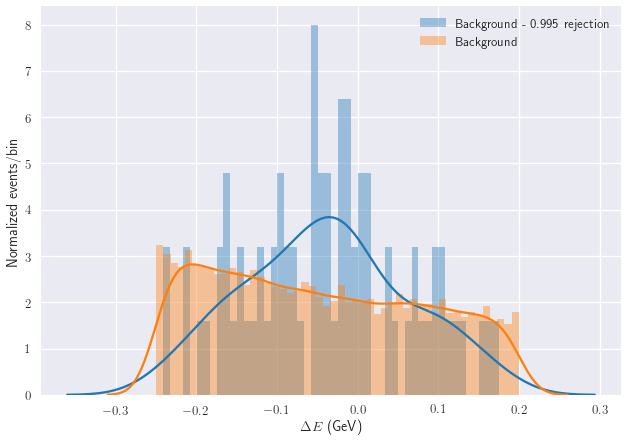

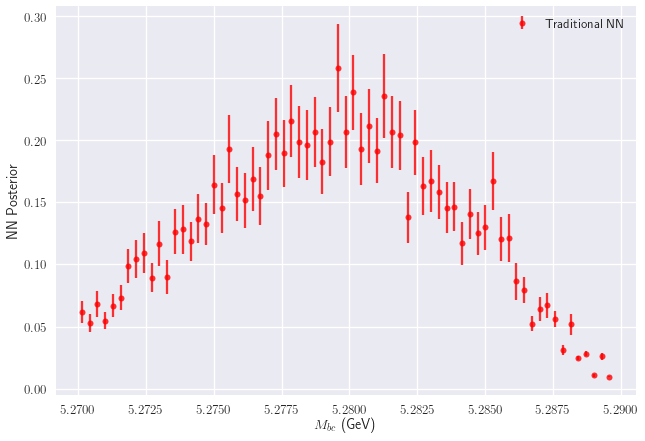

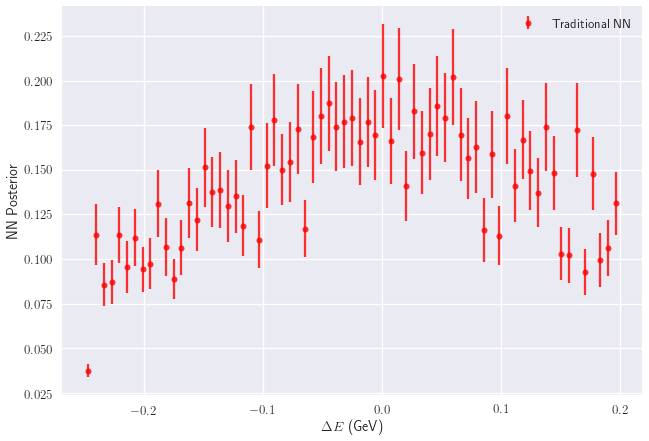

Epoch 8, Step 1319832 | Training Acc: 0.937 | Test Acc: 0.961 | Test Loss: 0.061 | Test AUC: 0.919 | Total loss: -7.074 | Rate: 1804 examples/s (499.33 s) 
Post-selection: 75
Normalized BG deviation:  1.51717305152


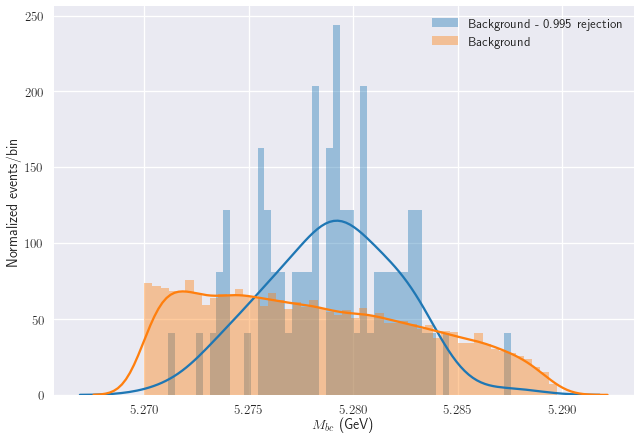

Post-selection: 75
Normalized BG deviation:  1.52232496697


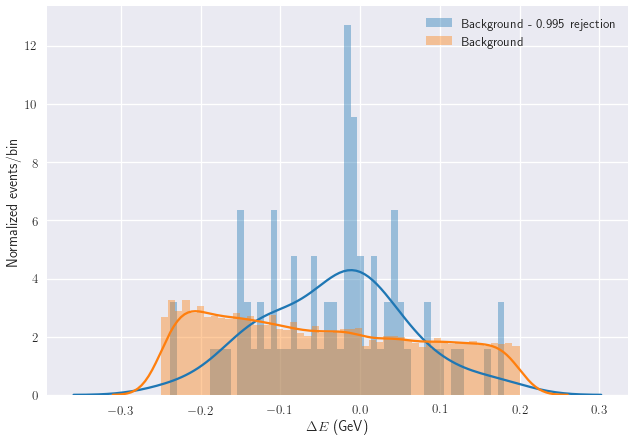

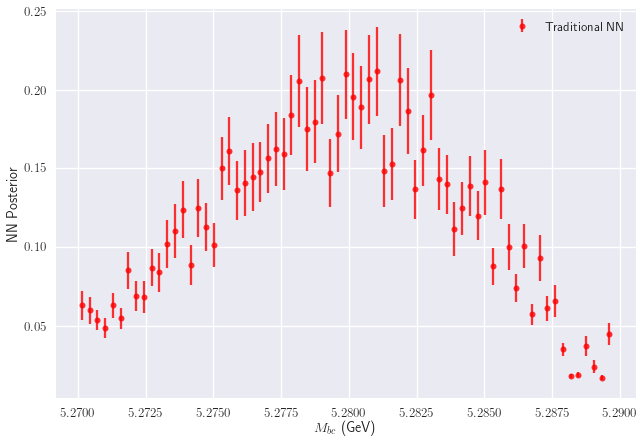

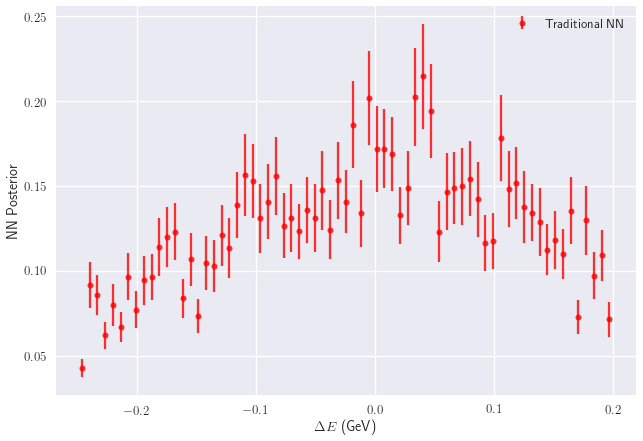

Graph saved to file: best/vDNN_adv-selu_B2Xsy_epoch9.ckpt-9
Epoch 9, Step 1319595 | Training Acc: 0.945 | Test Acc: 0.949 | Test Loss: 0.153 | Test AUC: 0.926 | Total loss: -8.610 | Rate: 387 examples/s (553.67 s) [*]
Post-selection: 75
Normalized BG deviation:  1.51736041957


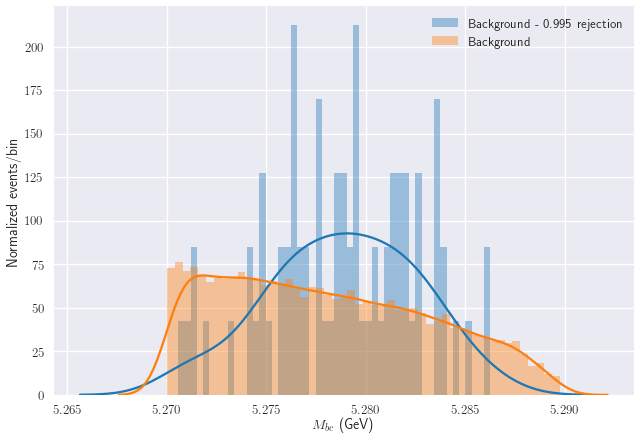

Post-selection: 75
Normalized BG deviation:  1.54126004116


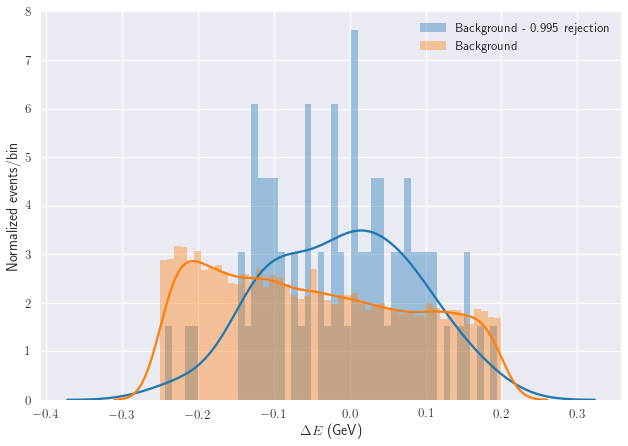

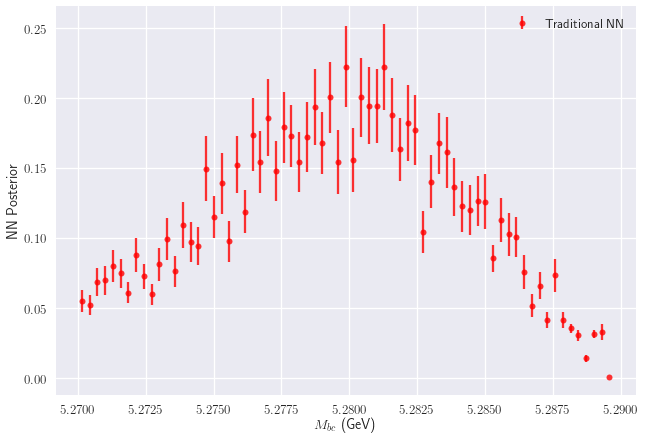

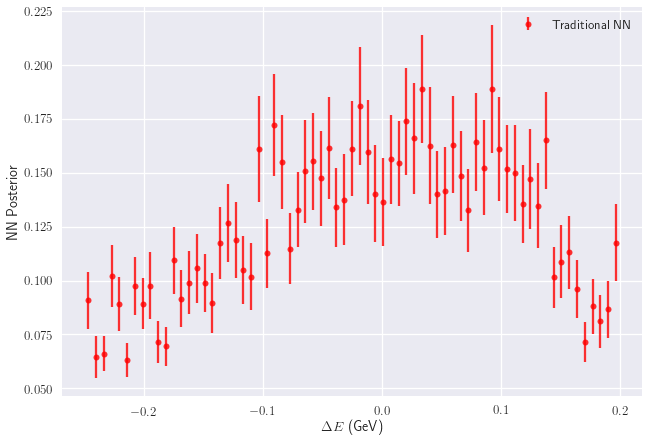

Graph saved to file: best/vDNN_adv-selu_B2Xsy_epoch10.ckpt-10
Epoch 10, Step 1319358 | Training Acc: 0.970 | Test Acc: 0.957 | Test Loss: 0.124 | Test AUC: 0.948 | Total loss: -7.649 | Rate: 276 examples/s (609.67 s) [*]
Post-selection: 76
Normalized BG deviation:  1.45941345902


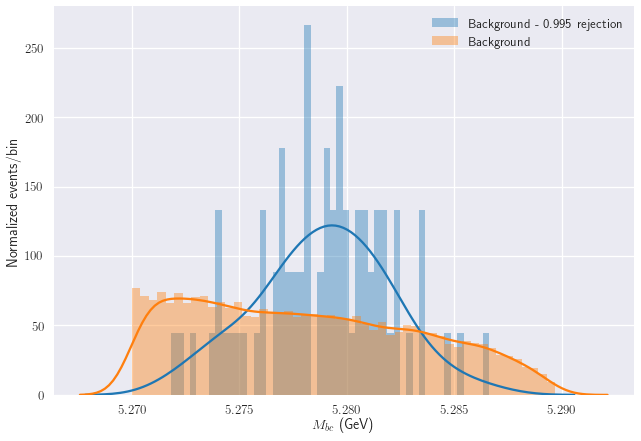

Post-selection: 76
Normalized BG deviation:  1.52422100026


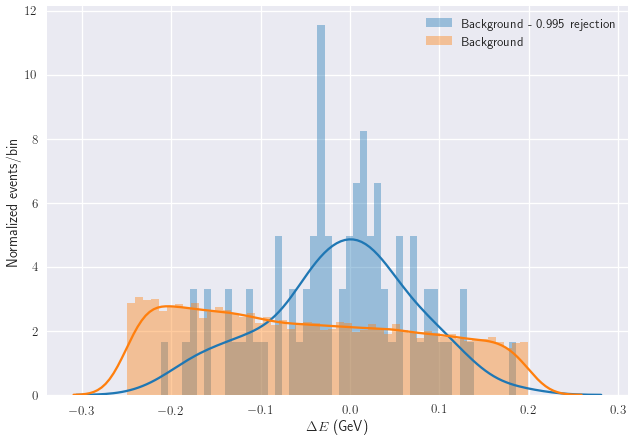

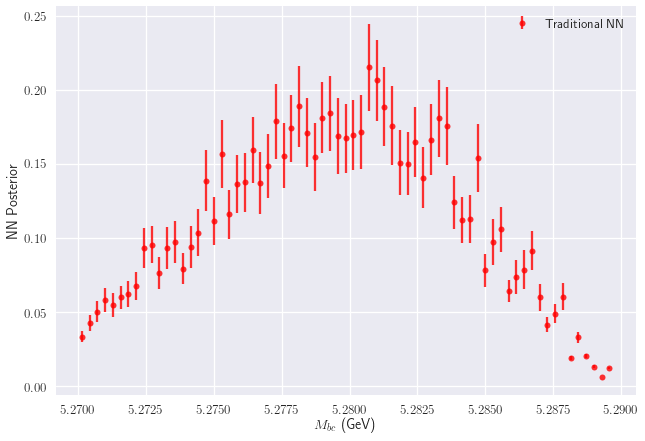

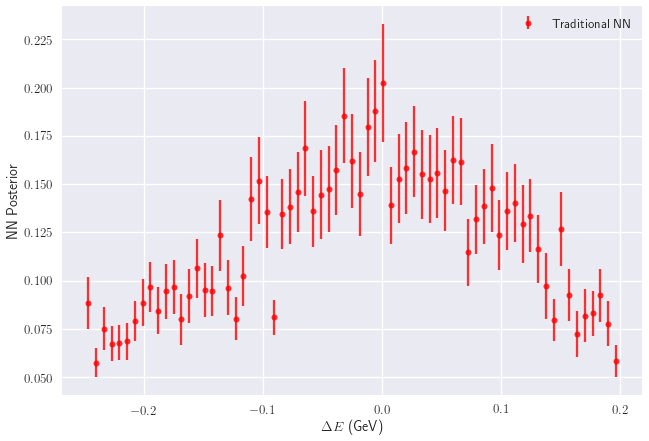

Graph saved to file: best/vDNN_adv-selu_B2Xsy_epoch11.ckpt-11
Epoch 11, Step 1319121 | Training Acc: 0.975 | Test Acc: 0.973 | Test Loss: 0.076 | Test AUC: 0.965 | Total loss: -6.864 | Rate: 393 examples/s (663.86 s) [*]
Post-selection: 76
Normalized BG deviation:  1.52992069214


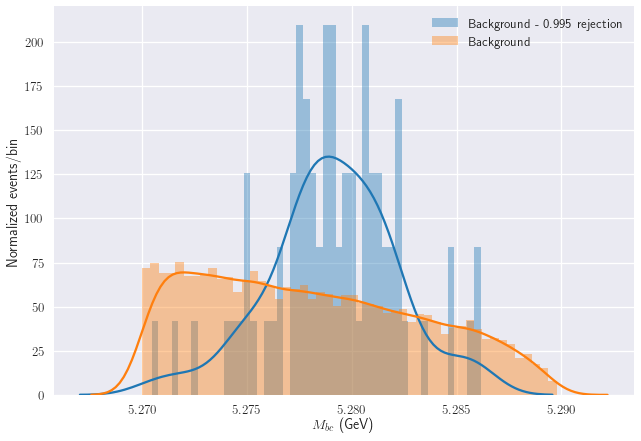

Post-selection: 76
Normalized BG deviation:  1.51471455725


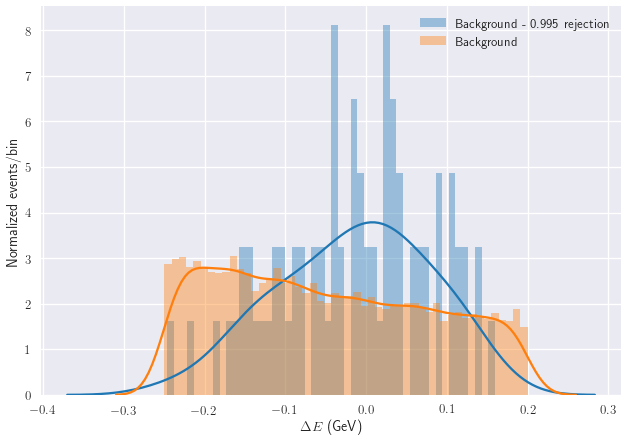

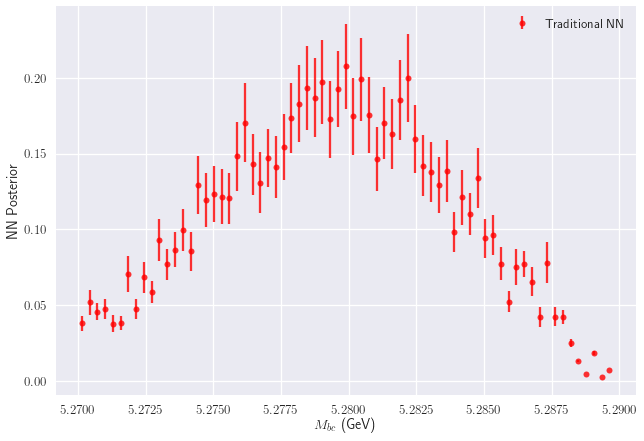

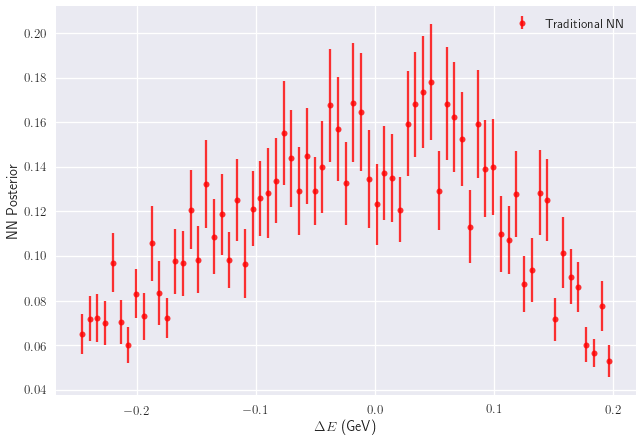

Epoch 12, Step 1318884 | Training Acc: 0.954 | Test Acc: 0.965 | Test Loss: 0.105 | Test AUC: 0.945 | Total loss: -7.687 | Rate: 1777 examples/s (718.20 s) 
Post-selection: 76
Normalized BG deviation:  1.51520303407


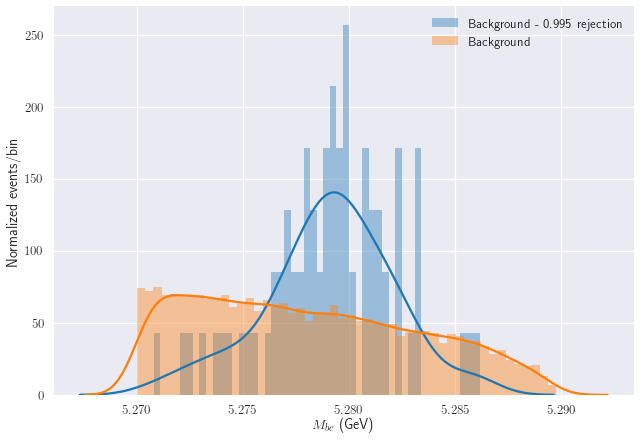

Post-selection: 76
Normalized BG deviation:  1.46406852808


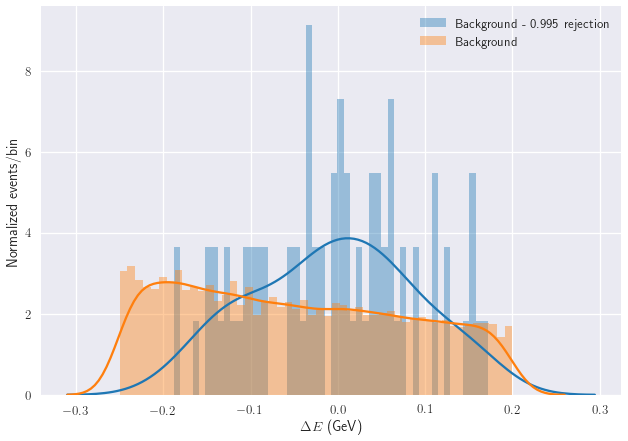

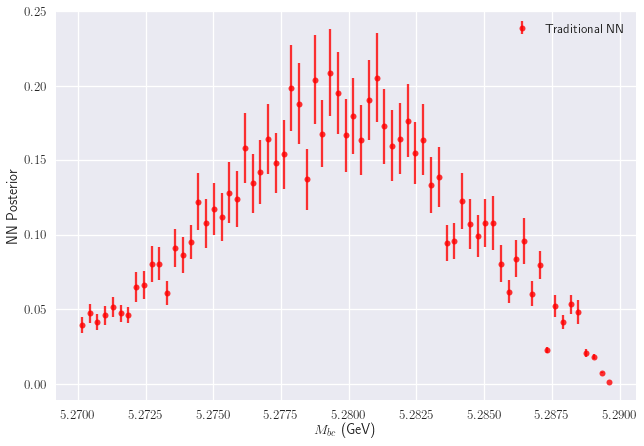

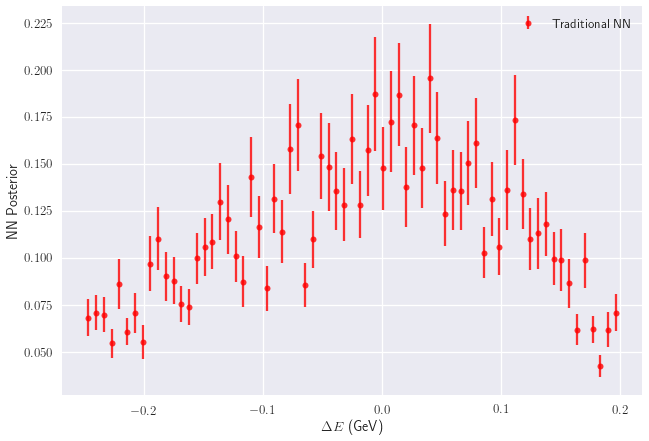

Epoch 13, Step 1318647 | Training Acc: 0.937 | Test Acc: 0.945 | Test Loss: 0.219 | Test AUC: 0.911 | Total loss: -8.724 | Rate: 1862 examples/s (772.63 s) 
Post-selection: 75
Normalized BG deviation:  1.4912106136


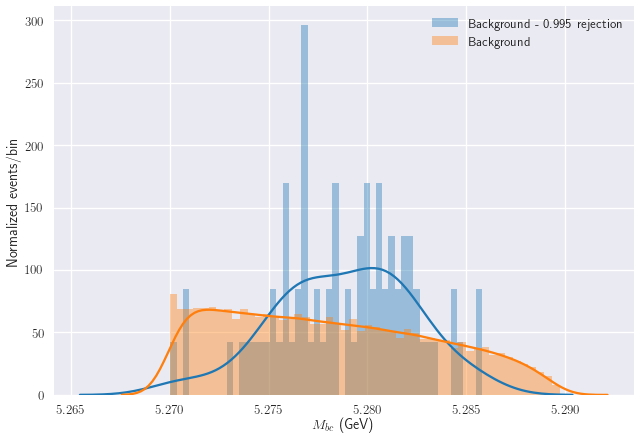

Post-selection: 75
Normalized BG deviation:  1.50898839138


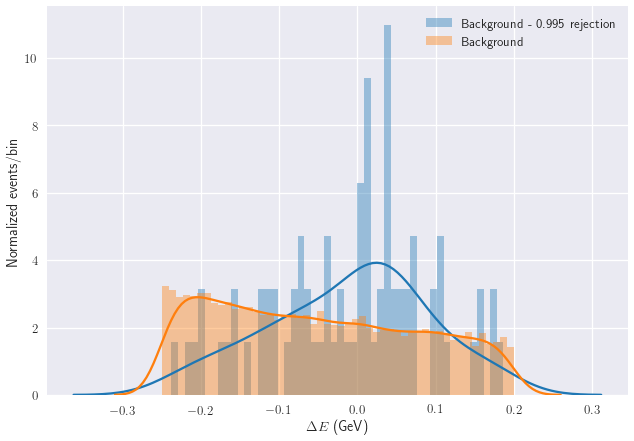

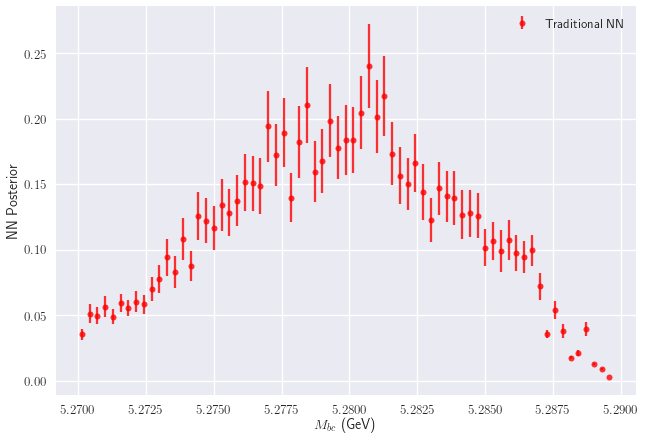

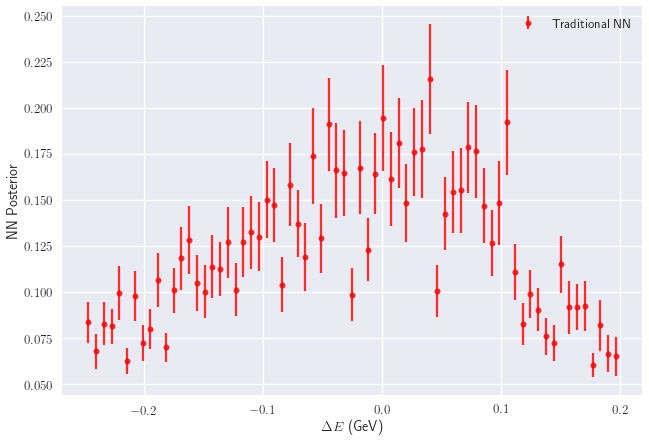

Epoch 14, Step 1318410 | Training Acc: 0.937 | Test Acc: 0.934 | Test Loss: 0.140 | Test AUC: 0.928 | Total loss: -7.767 | Rate: 1800 examples/s (827.31 s) 
Post-selection: 75
Normalized BG deviation:  1.58159273258


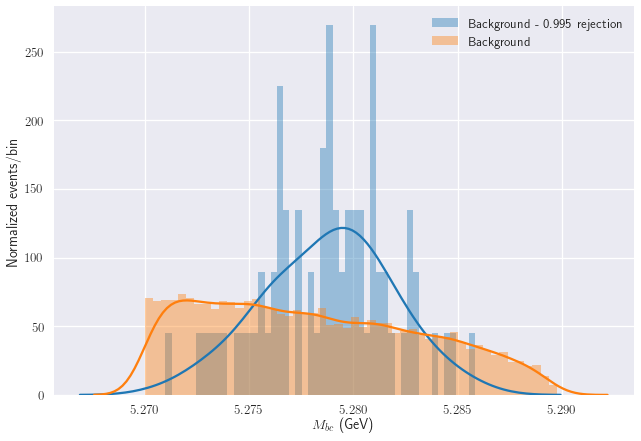

Post-selection: 75
Normalized BG deviation:  1.52164975797


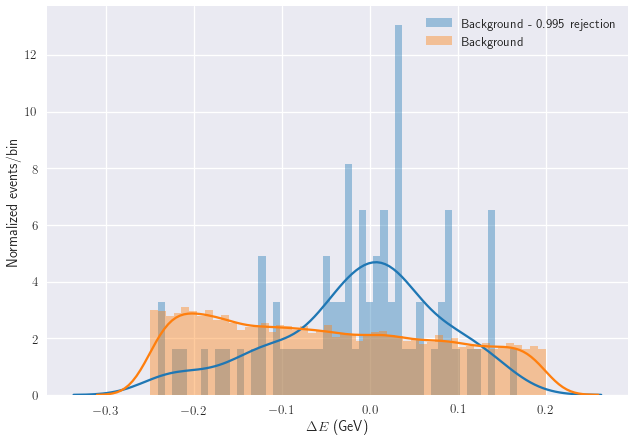

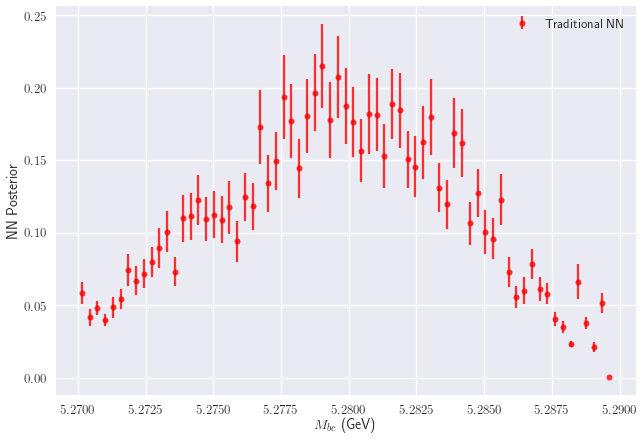

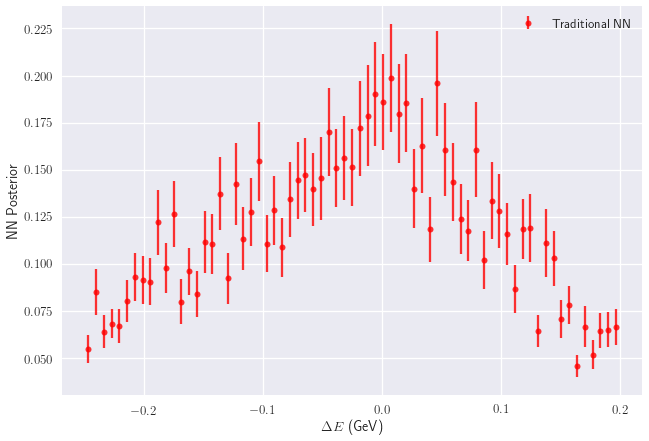

Epoch 15, Step 1318173 | Training Acc: 0.920 | Test Acc: 0.973 | Test Loss: 0.118 | Test AUC: 0.928 | Total loss: -7.739 | Rate: 1785 examples/s (882.41 s) 
Post-selection: 75
Normalized BG deviation:  1.49083206461


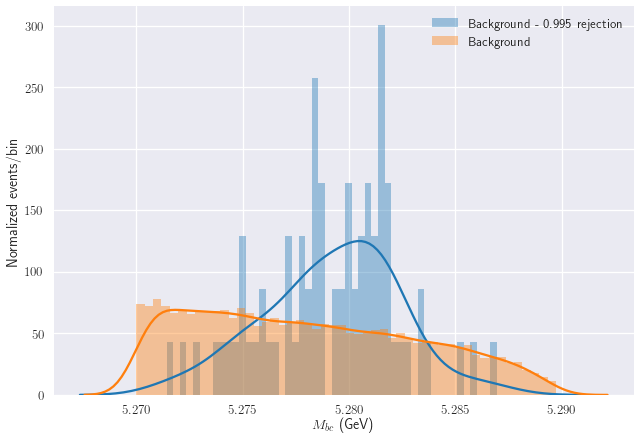

Post-selection: 75
Normalized BG deviation:  1.51783941219


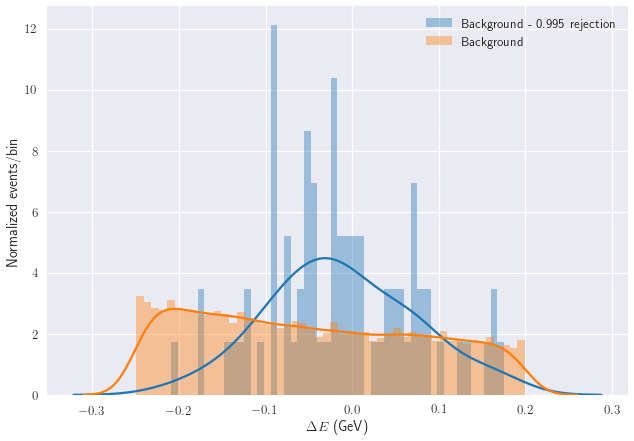

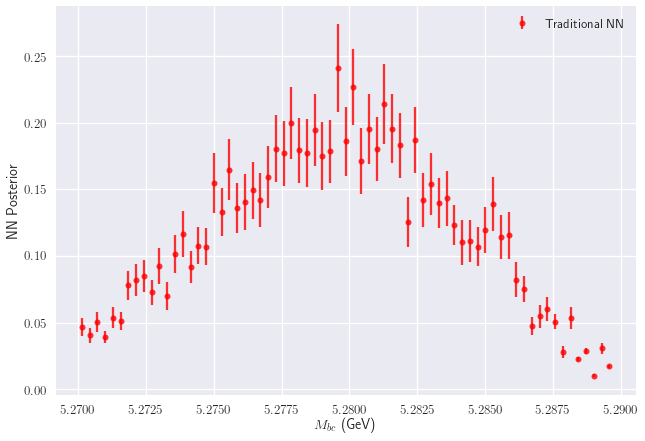

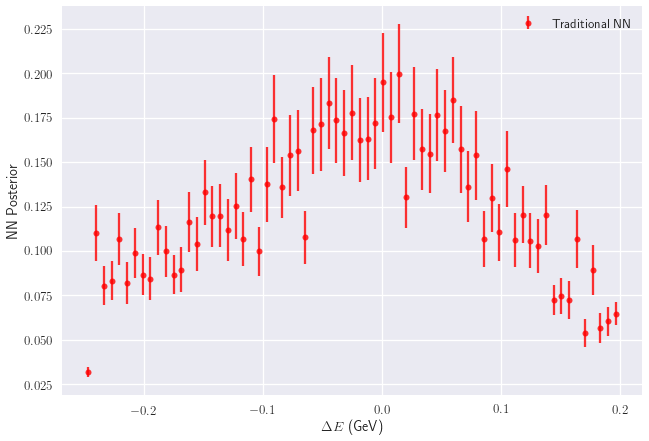

Graph saved to file: checkpoints/vDNN_adv-selu_B2Xsy_epoch16.ckpt-16
Epoch 16, Step 1317936 | Training Acc: 0.970 | Test Acc: 0.965 | Test Loss: 0.099 | Test AUC: 0.954 | Total loss: -8.630 | Rate: 369 examples/s (938.07 s) 
Post-selection: 75
Normalized BG deviation:  1.50779392338


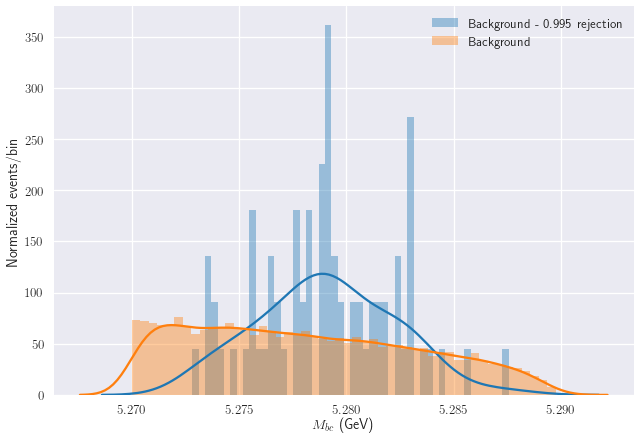

Post-selection: 75
Normalized BG deviation:  1.53051519155


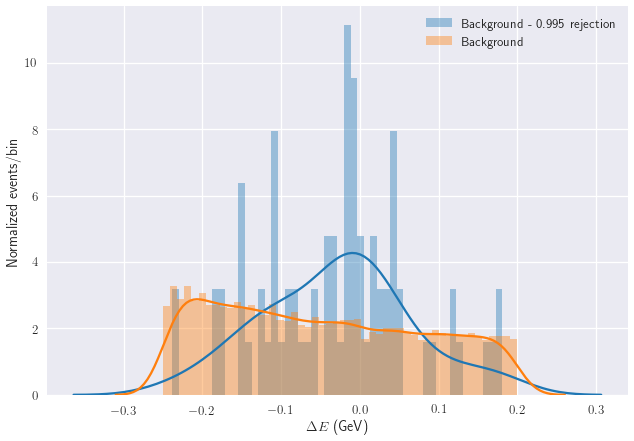

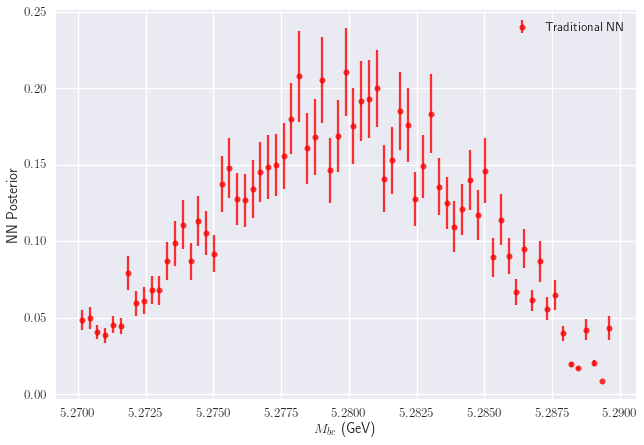

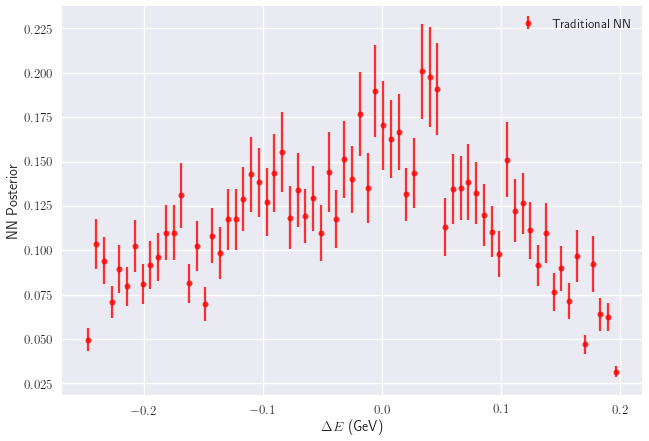

In [ ]:
train(config)#, restore=True)

Architecture: B2Xsy - adv-selu | Layers: 7 | Dropout: 0.95 | Base LR: 1e-05 | Epochs: 512
INFO:tensorflow:Restoring parameters from checkpoints/vDNN_adv-selu_B2Xsy_epoch48.ckpt-48
checkpoints/vDNN_adv-selu_B2Xsy_epoch48.ckpt-48 restored.
Graph saved to file: checkpoints/vDNN_adv-selu_B2Xsy_epoch0.ckpt-0
Epoch 0, Step 1321728 | Training Acc: 0.928 | Test Acc: 0.945 | Test Loss: 0.187 | Test AUC: 0.882 | Total loss: -10.989 | Rate: 299 examples/s (38.80 s) [*]
Post-selection: 6064


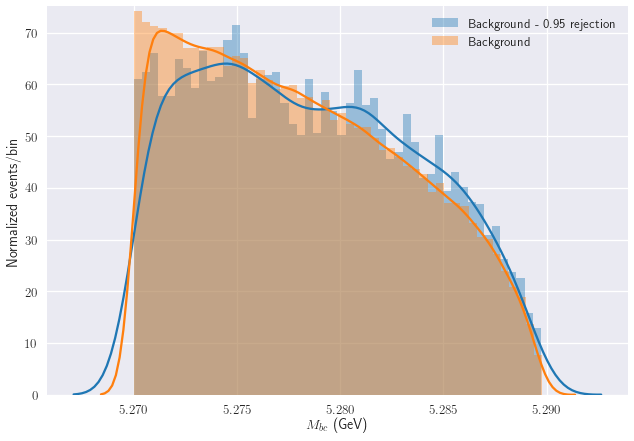

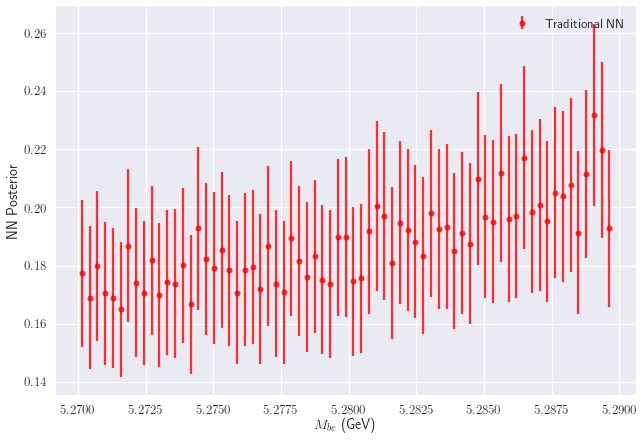

Epoch 1, Step 1321491 | Training Acc: 0.941 | Test Acc: 0.965 | Test Loss: 0.124 | Test AUC: 0.929 | Total loss: -14.267 | Rate: 1619 examples/s (79.92 s) [*]
Post-selection: 6064


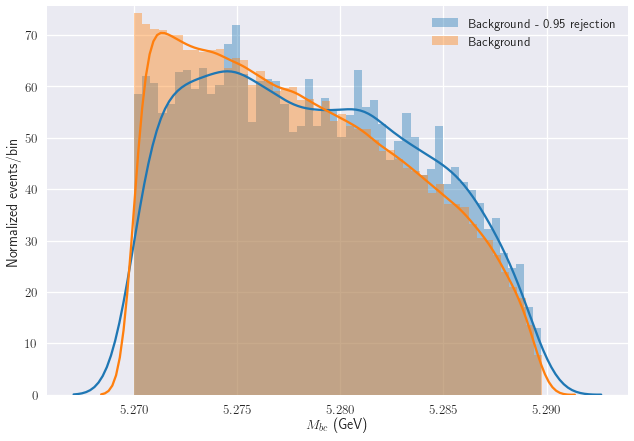

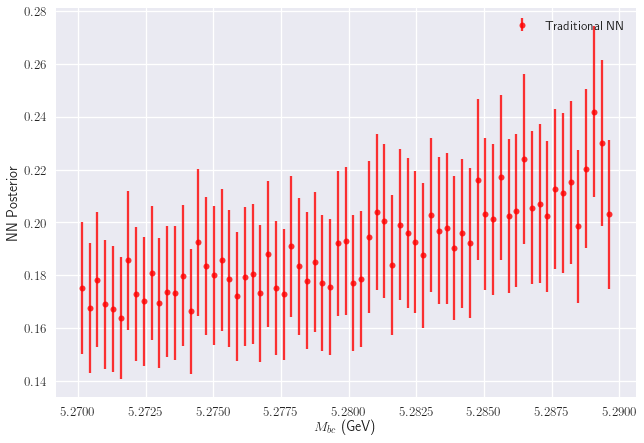

Epoch 2, Step 1321254 | Training Acc: 0.907 | Test Acc: 0.914 | Test Loss: 0.301 | Test AUC: 0.866 | Total loss: -22.281 | Rate: 1747 examples/s (119.02 s) 
Post-selection: 6064


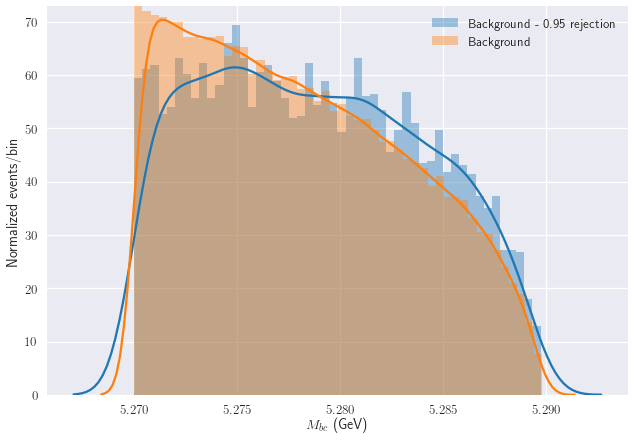

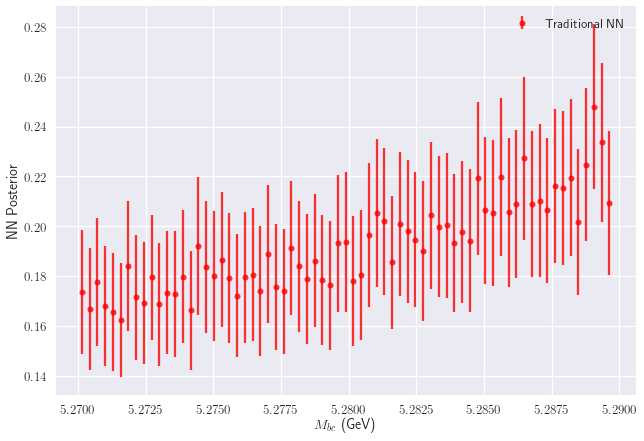

Epoch 3, Step 1321017 | Training Acc: 0.937 | Test Acc: 0.930 | Test Loss: 0.263 | Test AUC: 0.896 | Total loss: -21.931 | Rate: 1694 examples/s (157.98 s) 
Post-selection: 6064


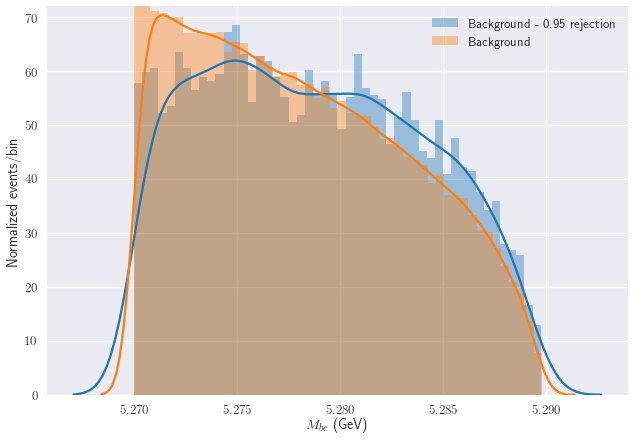

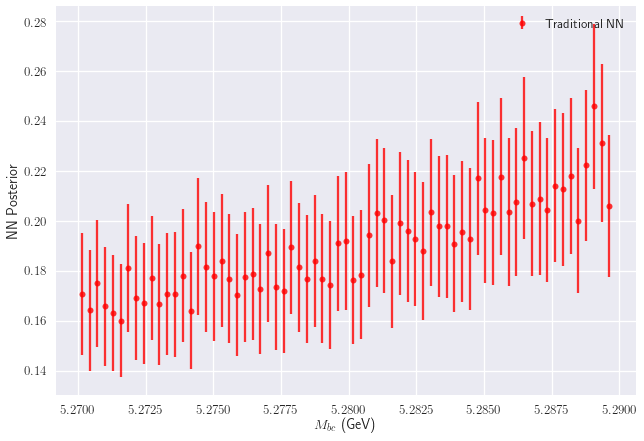

Epoch 4, Step 1320780 | Training Acc: 0.924 | Test Acc: 0.910 | Test Loss: 0.249 | Test AUC: 0.880 | Total loss: -19.028 | Rate: 1787 examples/s (196.81 s) 
Post-selection: 6064


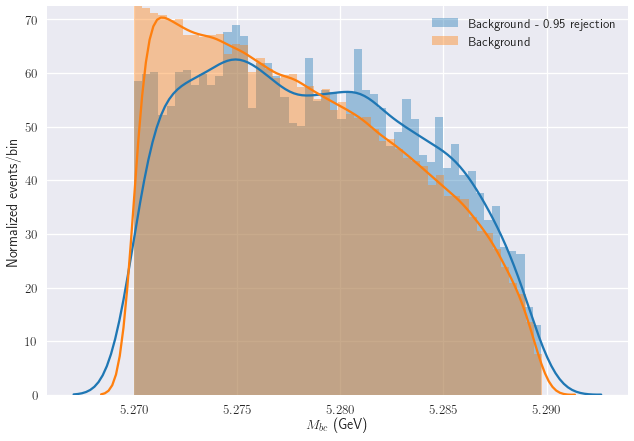

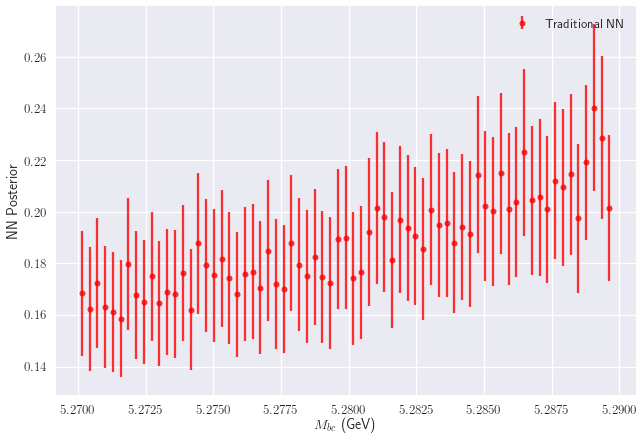

Epoch 5, Step 1320543 | Training Acc: 0.945 | Test Acc: 0.941 | Test Loss: 0.147 | Test AUC: 0.904 | Total loss: -17.739 | Rate: 1728 examples/s (235.63 s) 
Post-selection: 6064


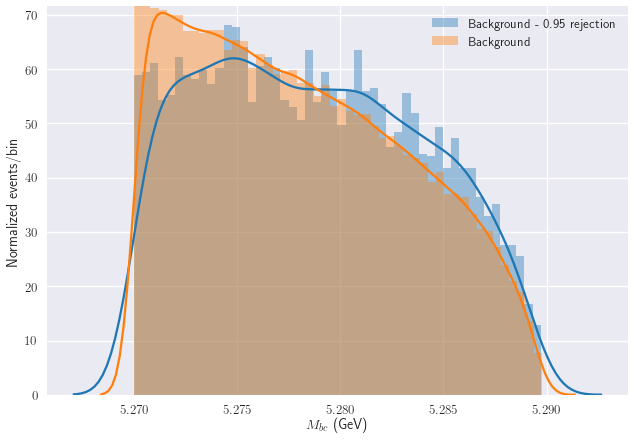

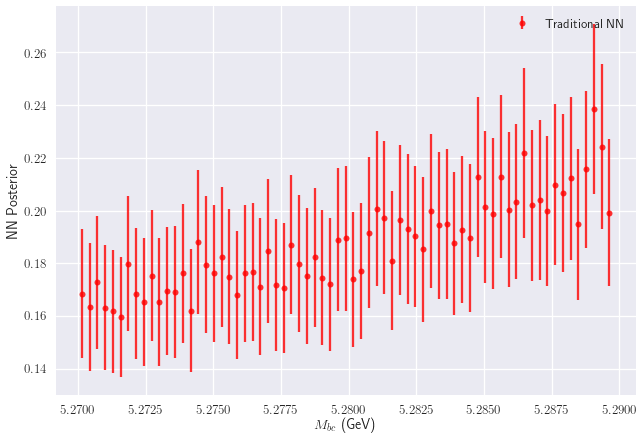

Epoch 6, Step 1320306 | Training Acc: 0.911 | Test Acc: 0.965 | Test Loss: 0.101 | Test AUC: 0.898 | Total loss: -6.515 | Rate: 1765 examples/s (274.23 s) 
Post-selection: 6064


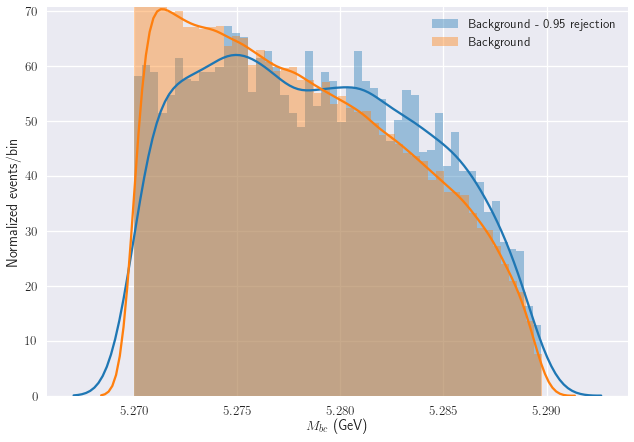

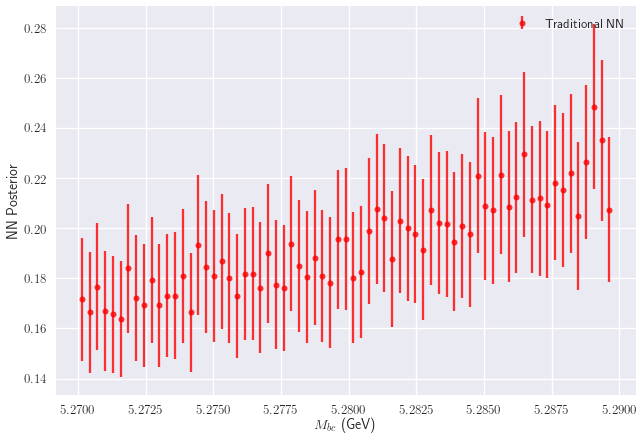

Epoch 7, Step 1320069 | Training Acc: 0.920 | Test Acc: 0.926 | Test Loss: 0.239 | Test AUC: 0.883 | Total loss: -0.150 | Rate: 1764 examples/s (313.15 s) 
Post-selection: 6064


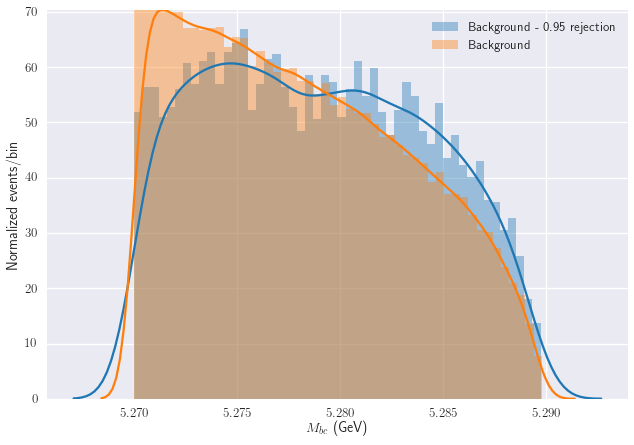

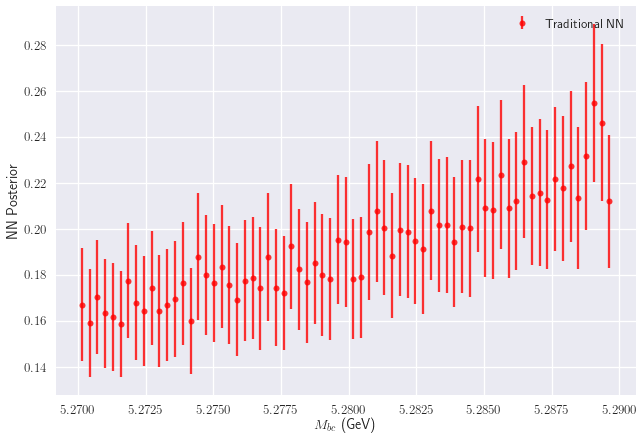

Epoch 8, Step 1319832 | Training Acc: 0.945 | Test Acc: 0.922 | Test Loss: 0.175 | Test AUC: 0.892 | Total loss: -17.710 | Rate: 1660 examples/s (351.97 s) 
Post-selection: 6064


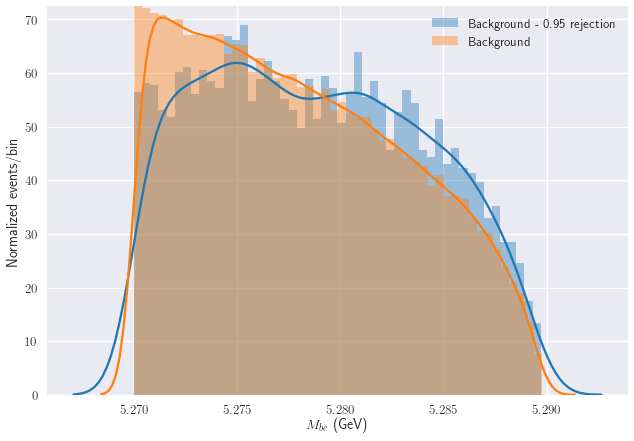

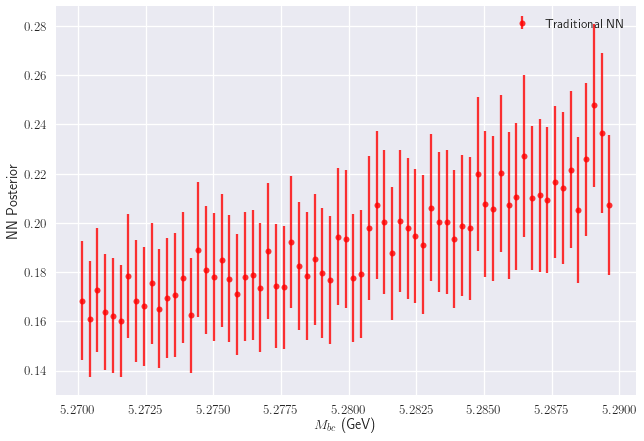

Epoch 9, Step 1319595 | Training Acc: 0.916 | Test Acc: 0.953 | Test Loss: 0.138 | Test AUC: 0.890 | Total loss: -11.581 | Rate: 1723 examples/s (390.77 s) 
Post-selection: 6064


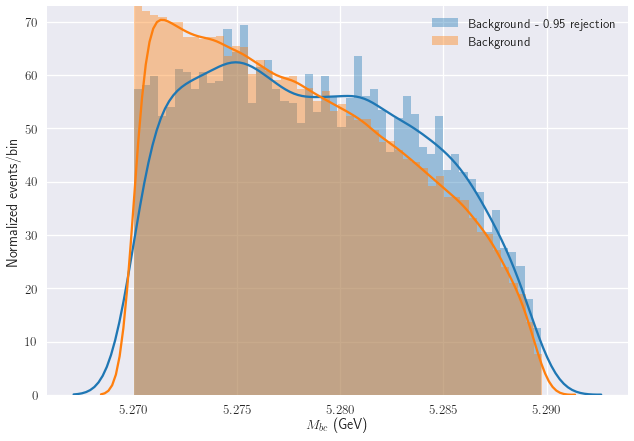

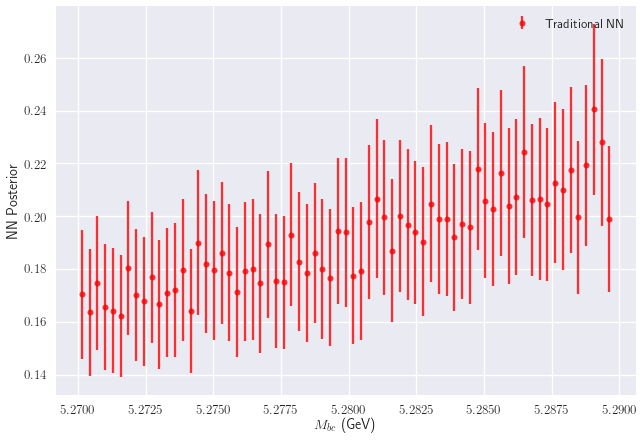

Epoch 10, Step 1319358 | Training Acc: 0.907 | Test Acc: 0.930 | Test Loss: 0.223 | Test AUC: 0.843 | Total loss: -15.697 | Rate: 1671 examples/s (429.44 s) 
Post-selection: 6064


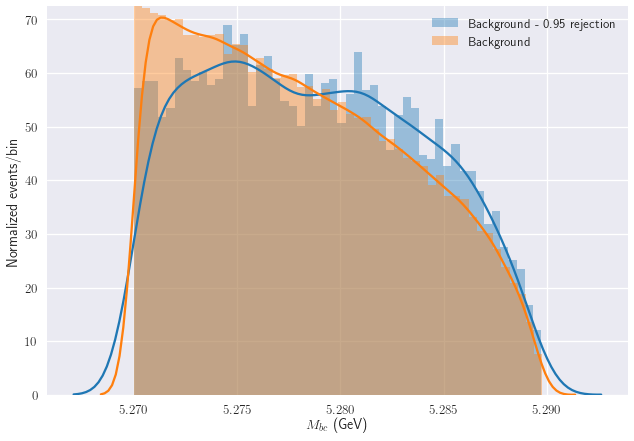

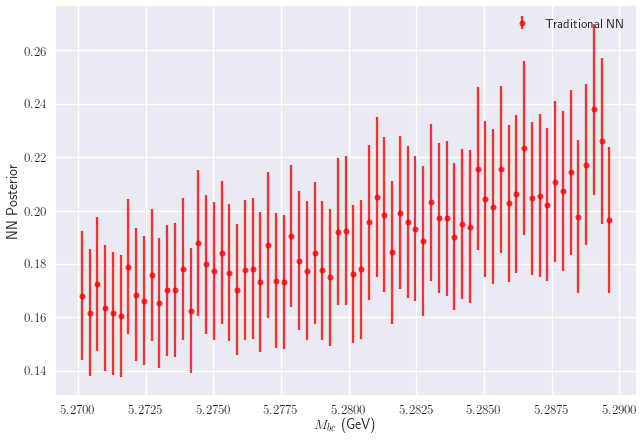

Epoch 11, Step 1319121 | Training Acc: 0.916 | Test Acc: 0.941 | Test Loss: 0.193 | Test AUC: 0.888 | Total loss: -18.096 | Rate: 1746 examples/s (468.07 s) 
Post-selection: 6064


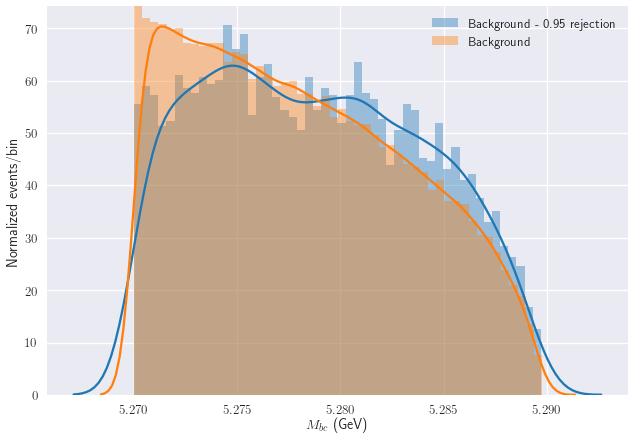

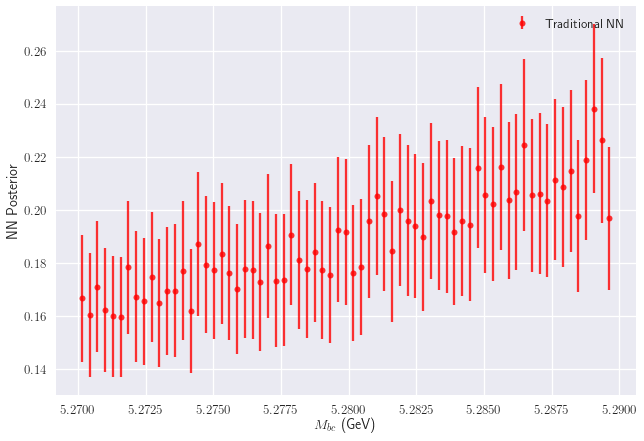

Epoch 12, Step 1318884 | Training Acc: 0.941 | Test Acc: 0.965 | Test Loss: 0.141 | Test AUC: 0.910 | Total loss: -9.609 | Rate: 1747 examples/s (506.82 s) 
Post-selection: 6064


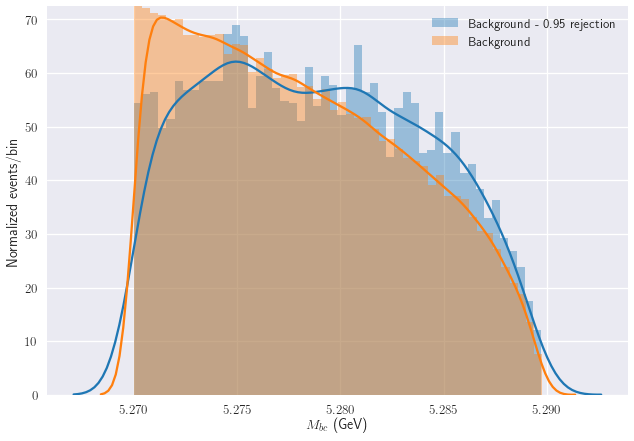

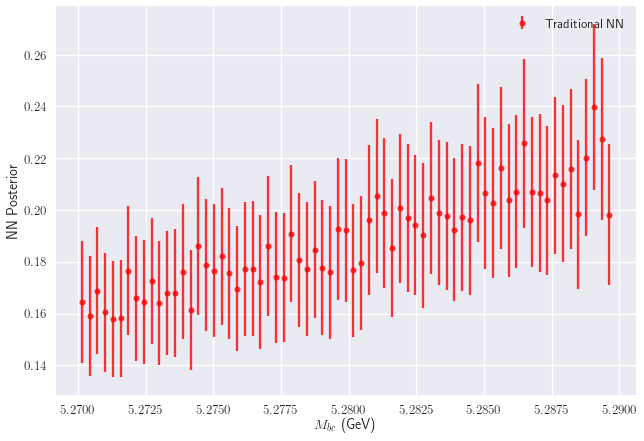

Epoch 13, Step 1318647 | Training Acc: 0.941 | Test Acc: 0.930 | Test Loss: 0.210 | Test AUC: 0.903 | Total loss: -12.618 | Rate: 1671 examples/s (546.47 s) 
Post-selection: 6064


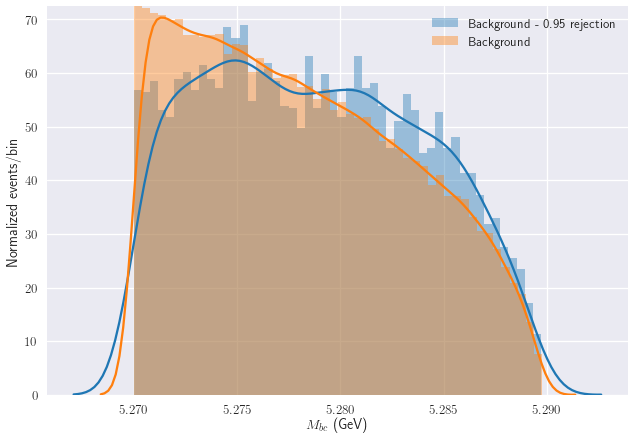

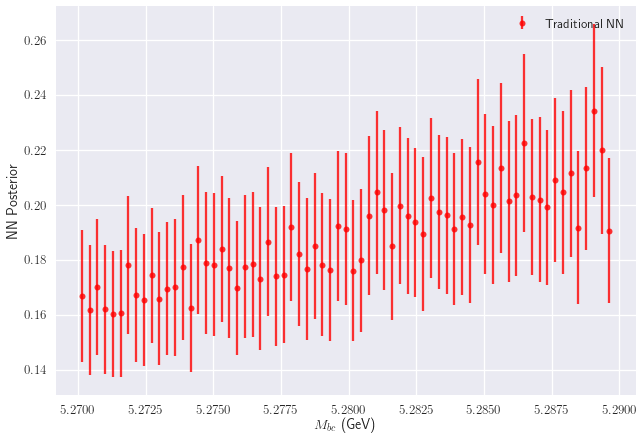

Epoch 14, Step 1318410 | Training Acc: 0.949 | Test Acc: 0.918 | Test Loss: 0.275 | Test AUC: 0.898 | Total loss: -24.035 | Rate: 1633 examples/s (585.33 s) 
Post-selection: 6064


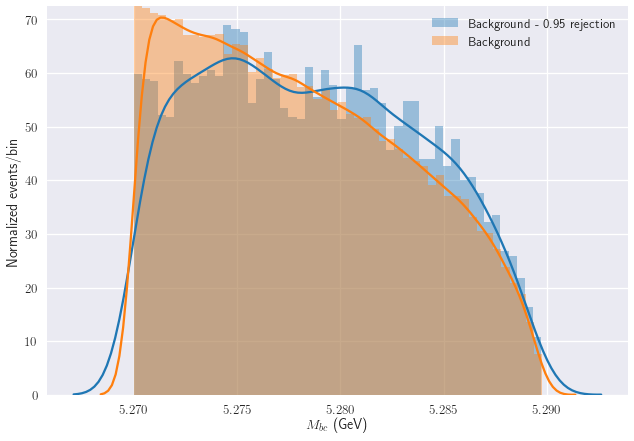

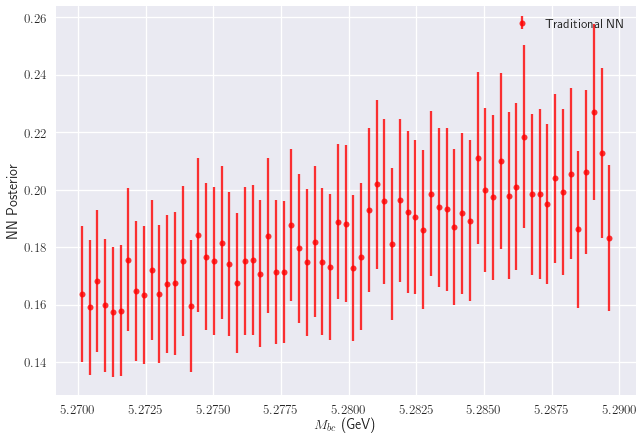

Epoch 15, Step 1318173 | Training Acc: 0.962 | Test Acc: 0.941 | Test Loss: 0.151 | Test AUC: 0.913 | Total loss: -12.024 | Rate: 1654 examples/s (625.10 s) 
Post-selection: 6064


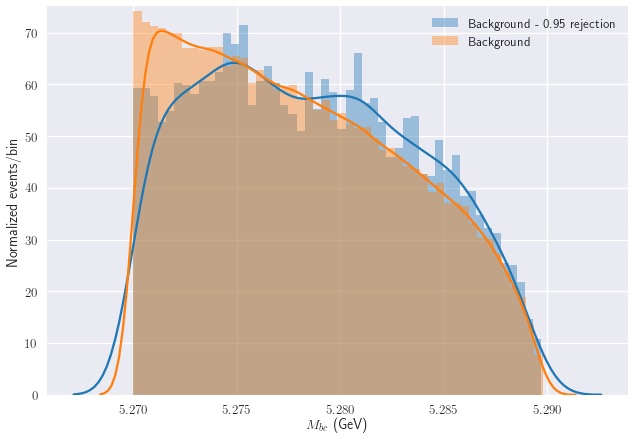

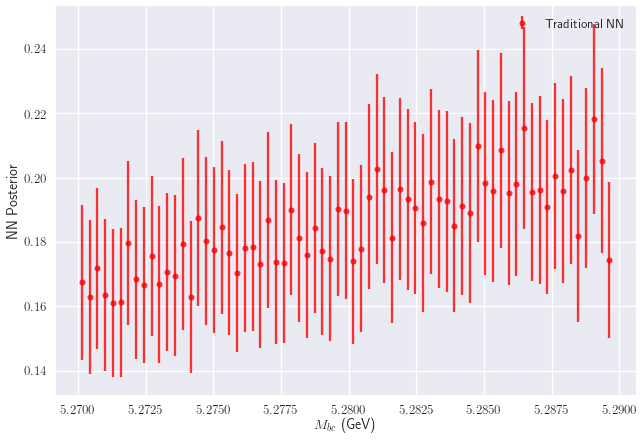

Graph saved to file: best/vDNN_adv-selu_B2Xsy_epoch16.ckpt-16
Graph saved to file: checkpoints/vDNN_adv-selu_B2Xsy_epoch16.ckpt-16
Epoch 16, Step 1317936 | Training Acc: 0.945 | Test Acc: 0.969 | Test Loss: 0.107 | Test AUC: 0.936 | Total loss: -17.540 | Rate: 109 examples/s (666.46 s) [*]
Post-selection: 6064


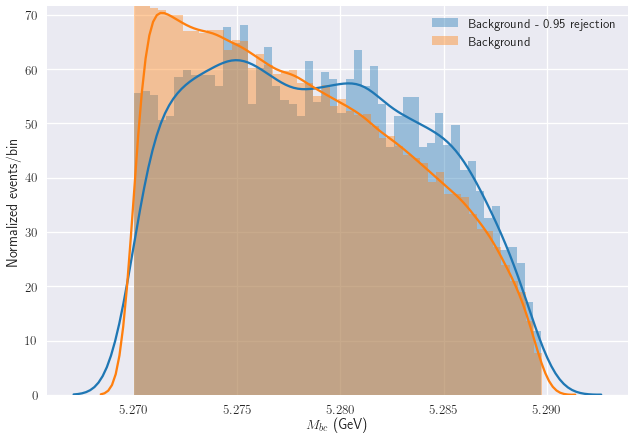

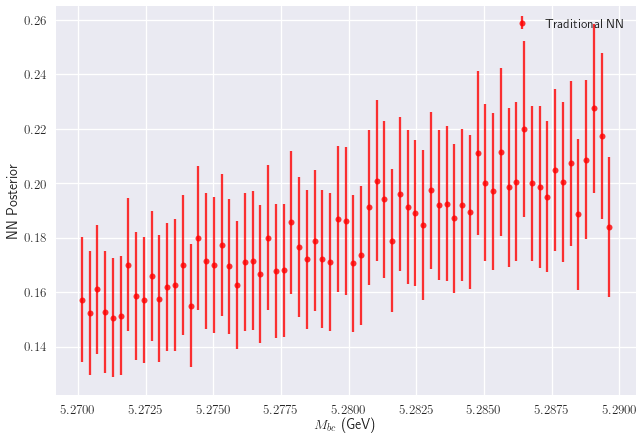

In [ ]:
train(config, restore=True)

#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

INFO:tensorflow:Restoring parameters from checkpoints/vDNN_adv-selu_B2Xsy_epoch16.ckpt-16
checkpoints/vDNN_adv-selu_B2Xsy_epoch16.ckpt-16 restored.
Validation accuracy: 0.935
AUC: 0.9737824346375283


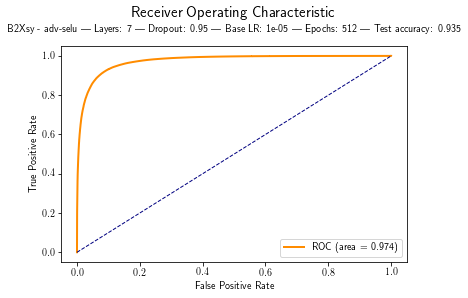

Plotting signal efficiency versus background rejection


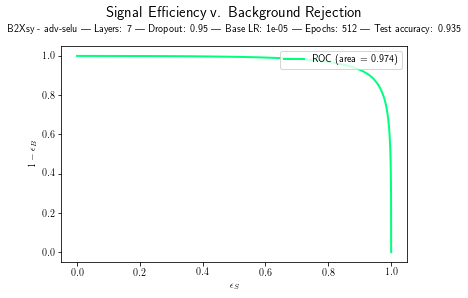

Inference complete. Duration: 20.6718 s


In [6]:
import os
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
labels, preds, output = vDNN.predict(ckpt)

# Add predictions to test set as a new column, save as HDF5
output = pd.Series(output, name='preds')
test = pd.concat([pdf_test, output], axis=1)

In [11]:
bkg = test[test['labels']<0.5]
sig = test[test['labels']==1]

In [16]:
post_cut = bkg[bkg['probs']>0.9]
post_sig = sig[sig['probs']>0.9]

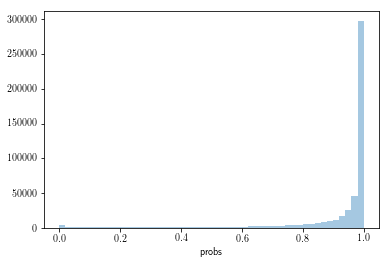

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(sig['probs'], kde=False)
plt.show()

In [7]:
test.to_hdf(os.path.join(directories.checkpoints, 'adv_mbc{}_preds.h5'.format(os.path.basename(directories.test))), key = 'df', format='t', data_columns=True)

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-talk')
plt.style.use('seaborn-pastel')

In [14]:
def normPlot(variable, pdf, epoch, signal, nbins=50, bkg_rejection=0.95):
    from scipy import stats
    titles={'mbc': r'$M_{bc}$ (GeV)', 'deltae': r'$\Delta E$ (GeV)', 'daughterInvM': r'$M_{X_q}$ (GeV)'}
    bkg = pdf[pdf['labels']<0.5]
    post_bkg = bkg.nlargest(int(bkg.shape[0]*(1-bkg_rejection)), columns=['preds'])
    threshold = post_bkg['preds'].min()
    print('Post-selection:', post_bkg.shape[0])
    if signal:
        sig = pdf[pdf['labels']==1]
        post_sig = pdf[(pdf['labels']==1) & (pdf['preds']>threshold)]
        sns.distplot(post_sig[variable], hist=True, kde=True, label='Signal - {} BG rejection'.format(bkg_rejection), bins=nbins,
                     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))
        sns.distplot(sig[variable], hist=True, kde=True, label='Signal', bins=nbins,
                     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))
    else:
        sns.distplot(post_bkg[variable], hist=True, kde=False, norm_hist=True, label='Background - {} BG rejection'.format(bkg_rejection), bins=nbins,# fit=stats.norm,
                     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))
        sns.distplot(bkg[variable], hist=True, kde=True, label='Background', bins=nbins,
                     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))
    plt.xlabel(r'{}'.format(titles[variable]))
    plt.ylabel(r'Normalized events/bin')
    plt.legend(loc = "best")
    plt.savefig('best/{}_adv-ep{}-nb.pdf'.format(variable, epoch), bbox_inches='tight',format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

Post-selection: 6064


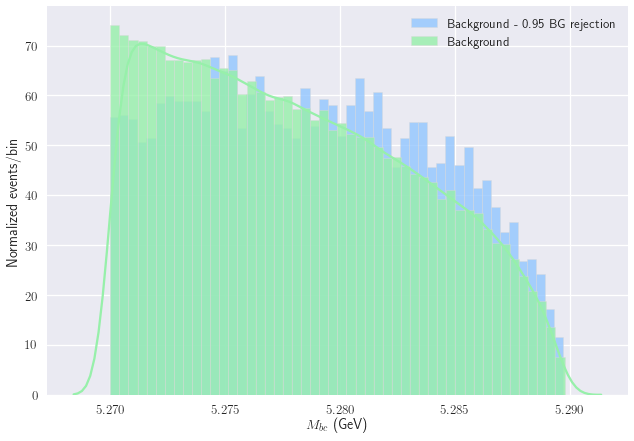

In [15]:
normPlot('mbc', test, signal=False, epoch='talk_bkg_mbc_adv-nn')